Script para sacar todo lo necesario para el proyecto 3

Importacion de librerias: 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import Ridge
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from yellowbrick.regressor import ResidualsPlot
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from scipy.stats import normaltest
from scipy.stats import linregress
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.metrics import *
import sklearn.metrics as metrics
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LassoCV,Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


from scipy.stats import chi2_contingency
from math import sqrt

# Descripción del conjunto de datos

El archivo **todoscsvs.csv** reúne 10 años (2014–2023) de denuncias por violencia —incluyendo violencia intrafamiliar— registradas ante instituciones oficiales en Guatemala. Cada fila es una denuncia; cada columna, un atributo.

## Alcance temporal y geográfico
- **Periodo:** Enero 2014 – Diciembre 2023  
- **Ubicación:** Departamentos y municipios de Guatemala  

## Tamaño del dataset
- **Filas (observaciones):** corresponde a cada denuncia registrada  
- **Columnas (variables):** 70  

## Grupos de variables

| Categoría | Variables | Tipo de dato | Descripción breve |
|-----------|-----------|--------------|-------------------|
| 📅 Fecha ocurrencia | dia_ocurrencia, mes_ocurrencia, anio_ocurrencia | Categórico | Día, mes y año en que ocurrió el hecho |
| 📍 Ubicación ocurrencia | dep_municipio_ocurrencia | Categórico | Código (XXYY) de departamento+municipio donde ocurrió el hecho |
| 🚨 Tipo de agresión | tipo_agresion | Categórico | Código del tipo de agresión sufrida |
| 📅 Fecha registro | dia_registro, mes_registro, anio_registro | Categórico | Día, mes y año en que se registró la denuncia |
| 📍 Ubicación registro | dep_municipio_registro, departamento_registro | Categórico | Código municipio y departamento donde se registró la denuncia |
| 🗣 Reportante | quien_reporta | Categórico | Código de la persona que reportó el hecho |
| 👤 Víctima | sexo_victima, edad_victima, total_hijos_victima, hijos_hombres_victima, hijas_mujeres_victima, alfabeta_victima, escolaridad_victima, estado_civil_victima, pueblo_victima, nacionalidad_victima, trabaja_victima, ocupacion_victima, dedica_victima, discapacidad_victima, tipo_discapacidad_victima, relacion_victima_agresor, otras_victimas_total, otras_victimas_hombres, otras_victimas_mujeres, otras_victimas_ninos, otras_victimas_ninas | Mixto | Datos demográficos y contexto de la víctima |
| 👥 Agresor | sexo_agresor, edad_agresor, alfabeta_agresor, escolaridad_agresor, estado_civil_agresor, AGR_GURPET (pueblo_agresor), nacionalidad_agresor, trabaja_agresor, ocupacion_agresor, dedica_agresor, otros_agresores_total, otros_agresores_hombres, otros_agresores_mujeres, otros_agresores_ninos, otros_agresores_ninas | Mixto | Datos demográficos y contexto del agresor |
| 🏛 Instituciones | institucion_denuncia_previa, institucion_registro, organismo_jurisdiccional, conducente, organismo_remite | Categórico | Instituciones involucradas en la denuncia |
| 📜 Legislación y medidas | ley_aplicable, medidas_seguridad, tipo_medida, ARTICULOVCM1–4, ARTICULOCODPEN1–4, ARTICULOTRAS1–4 | Categórico | Leyes aplicadas y medidas judiciales |
| 🔢 Identificación | numero_boleta | Numérico | Folio interno de la denuncia |


Leer datos de un csv

In [14]:
df = pd.read_csv("todoscsvs.csv", low_memory=False)

# - Analisis Exploratorio #

- Corregir tipos de datos

In [15]:
for prefix in ("ocurrencia", "registro"):
    for unit in ("dia", "mes", "anio"):
        col = f"{unit}_{prefix}"
        df[col] = df[col].astype("Int64").astype("category")

# Crear columnas datetime completas
df["fecha_ocurrencia"] = pd.to_datetime(
    df[['anio_ocurrencia','mes_ocurrencia','dia_ocurrencia']]
      .rename(columns={'anio_ocurrencia':'year','mes_ocurrencia':'month','dia_ocurrencia':'day'}),
    errors='coerce'
)
df["fecha_registro"] = pd.to_datetime(
    df[['anio_registro','mes_registro','dia_registro']]
      .rename(columns={'anio_registro':'year','mes_registro':'month','dia_registro':'day'}),
    errors='coerce'
)

# Separar códigos departamento/municipio (formato XXYY)
for col, dep, mun in [
    ("dep_municipio_ocurrencia", "cod_dep_ocurrencia", "cod_mun_ocurrencia"),
    ("dep_municipio_registro",   "cod_dep_registro",   "cod_mun_registro")
]:
    df[[dep, mun]] = (
        df[col].astype(str).str.zfill(4).str.extract(r'^(\d{2})(\d{2})$')
    )

# Convertir todas las columnas de texto y códigos a categoría
cat_cols = df.select_dtypes(include="object").columns.tolist() + [
    "cod_dep_ocurrencia", "cod_mun_ocurrencia", "cod_dep_registro", "cod_mun_registro"
]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

- Visión general

In [16]:
print("📊 Dimensiones del dataset:", df.shape)
print("\n🔍 Conteo por tipo de dato:")
display(df.dtypes.value_counts())

print("\n📋 Primeras 5 filas:")
display(df.head())

print("\n❓ Valores faltantes:")
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].to_frame("faltantes"))

print("\n📈 Estadísticas descriptivas (todas las variables):")
display(df.describe(include='all').T)

print("\nℹ️ Información completa:")
df.info()

📊 Dimensiones del dataset: (328959, 76)

🔍 Conteo por tipo de dato:


float64           63
category           4
datetime64[ns]     2
category           1
category           1
category           1
category           1
category           1
category           1
category           1
Name: count, dtype: int64


📋 Primeras 5 filas:


dia_ocurrencia mes_ocurrencia anio_ocurrencia  dep_municipio_ocurrencia  \
0              4              2            2014                    1708.0   
1             12              1            2014                    1505.0   
2              8              4            2014                     501.0   
3             14              4            2014                    1107.0   
4             14              4            2014                    1101.0   

   tipo_agresion dia_registro mes_registro anio_registro  \
0         1122.0            5            2          2014   
1         2122.0           12            2          2014   
2         1122.0            8            4          2014   
3         1122.0           14            4          2014   
4         1122.0           15            4          2014   

   dep_municipio_registro  quien_reporta  ...  ARTICULOTRAS4  \
0                  1101.0            3.0  ...            NaN   
1                  1505.0            2.0  ...            NaN   
2                   501.0            3.0  ...            NaN   
3                  1101.0            3.0  ...            NaN   
4                  1101.0            3.0  ...            NaN   

   organismo_remite  numero_boleta  departamento_registro  fecha_ocurrencia  \
0               NaN            NaN                    NaN        2014-02-04   
1               NaN            NaN                    NaN        2014-01-12   
2               NaN            NaN                    NaN        2014-04-08   
3               NaN            NaN                    NaN        2014-04-14   
4               NaN            NaN                    NaN        2014-04-14   

   fecha_registro  cod_dep_ocurrencia  cod_mun_ocurrencia  cod_dep_registro  \
0      2014-02-05                 NaN                 NaN               NaN   
1      2014-02-12                 NaN                 NaN               NaN   
2      2014-04-08                 NaN                 NaN               NaN   
3      2014-04-14                 NaN                 NaN               NaN   
4      2014-04-15                 NaN                 NaN               NaN   

   cod_mun_registro  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 76 columns]


❓ Valores faltantes:


faltantes
cod_mun_registro                328959
cod_dep_registro                328959
cod_mun_ocurrencia              328959
cod_dep_ocurrencia              328959
ARTICULOTRAS2                   326868
ARTICULOTRAS3                   326868
ARTICULOTRAS4                   326868
ARTICULOTRAS1                   326868
ARTICULOCODPEN1                 326010
ARTICULOCODPEN4                 326010
ARTICULOCODPEN2                 326010
ARTICULOCODPEN3                 326010
tipo_discapacidad_victima       319368
departamento_registro           291611
institucion_denuncia_previa     286385
ARTICULOVCM3                    283210
ARTICULOVCM2                    283210
ARTICULOVCM1                    283210
ARTICULOVCM4                    283210
dedica_agresor                  253437
numero_boleta                   217982
ocupacion_victima               216135
conducente                      204277
organismo_jurisdiccional        204277
organismo_remite                204277
tipo_medida                     149851
medidas_seguridad               149839
ley_aplicable                   148411
dedica_victima                  113238
ocupacion_agresor                71131
fecha_ocurrencia                  3740
hijas_mujeres_victima             1674
total_hijos_victima               1674
estado_civil_victima              1674
hijos_hombres_victima             1674
escolaridad_victima                685
alfabeta_victima                   685
trabaja_victima                    685
estado_civil_agresor                24


📈 Estadísticas descriptivas (todas las variables):


count unique     top     freq  \
dia_ocurrencia            328959.0   32.0     1.0  13745.0   
mes_ocurrencia            328959.0   13.0     5.0  28816.0   
anio_ocurrencia           328959.0   25.0  2022.0  36565.0   
dep_municipio_ocurrencia  328959.0    NaN     NaN      NaN   
tipo_agresion             328959.0    NaN     NaN      NaN   
...                            ...    ...     ...      ...   
fecha_registro              328959    NaN     NaN      NaN   
cod_dep_ocurrencia               0      0     NaN      NaN   
cod_mun_ocurrencia               0      0     NaN      NaN   
cod_dep_registro                 0      0     NaN      NaN   
cod_mun_registro                 0      0     NaN      NaN   

                                                   mean                  min  \
dia_ocurrencia                                      NaN                  NaN   
mes_ocurrencia                                      NaN                  NaN   
anio_ocurrencia                                     NaN                  NaN   
dep_municipio_ocurrencia                     888.149076                  1.0   
tipo_agresion                               1612.877264               1111.0   
...                                                 ...                  ...   
fecha_registro            2019-02-13 21:53:37.126754560  2014-01-01 00:00:00   
cod_dep_ocurrencia                                  NaN                  NaN   
cod_mun_ocurrencia                                  NaN                  NaN   
cod_dep_registro                                    NaN                  NaN   
cod_mun_registro                                    NaN                  NaN   

                                          25%                  50%  \
dia_ocurrencia                            NaN                  NaN   
mes_ocurrencia                            NaN                  NaN   
anio_ocurrencia                           NaN                  NaN   
dep_municipio_ocurrencia                115.0                903.0   
tipo_agresion                          1122.0               1222.0   
...                                       ...                  ...   
fecha_registro            2016-06-27 00:00:00  2019-03-16 00:00:00   
cod_dep_ocurrencia                        NaN                  NaN   
cod_mun_ocurrencia                        NaN                  NaN   
cod_dep_registro                          NaN                  NaN   
cod_mun_registro                          NaN                  NaN   

                                          75%                  max         std  
dia_ocurrencia                            NaN                  NaN         NaN  
mes_ocurrencia                            NaN                  NaN         NaN  
anio_ocurrencia                           NaN                  NaN         NaN  
dep_municipio_ocurrencia               1504.0               9999.0  848.898045  
tipo_agresion                          2122.0               2221.0  491.062758  
...                                       ...                  ...         ...  
fecha_registro            2021-10-13 00:00:00  2023-12-31 00:00:00         NaN  
cod_dep_ocurrencia                        NaN                  NaN         NaN  
cod_mun_ocurrencia                        NaN                  NaN         NaN  
cod_dep_registro                          NaN                  NaN         NaN  
cod_mun_registro                          NaN                  NaN         NaN  

[76 rows x 11 columns]


ℹ️ Información completa:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328959 entries, 0 to 328958
Data columns (total 76 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   dia_ocurrencia               328959 non-null  category      
 1   mes_ocurrencia               328959 non-null  category      
 2   anio_ocurrencia              328959 non-null  category      
 3   dep_municipio_ocurrencia     328959 non-null  float64       
 4   tipo_agresion                328959 non-null  float64       
 5   dia_registro                 328959 non-null  category      
 6   mes_registro                 328959 non-null  category      
 7   anio_registro                328959 non-null  category      
 8   dep_municipio_registro       328959 non-null  float64       
 9   quien_reporta                328959 non-null  float64       
 10  sexo_victima                 328959 non-null  float64       
 11  

- Arreglamos el dataset

In [17]:
# Reemplazar valores numericos vacios por la mediana.
numericas = df.select_dtypes(include=['number']).columns
for col in numericas:
    df[col] = df[col].fillna(df[col].median())  

# Reemplazar valores no numericos por la moda
no_numericas = df.select_dtypes(exclude=['number']).columns
for col in no_numericas:
    df[col] = df[col].fillna(df[col].mode()[0]) 


KeyError: 0

- Volvemos a revisar el conjunto de datos. 

In [ ]:
print("\n❓ Valores faltantes:")
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].to_frame("faltantes"))


❓ Valores faltantes:


Empty DataFrame
Columns: [faltantes]
Index: []

- Ya nuestro dataFrame ya no tiene valores vacios.

- Tomamos solo las numericas para realizar una matriz de correlacion

In [ ]:
columnas_numericas = df.select_dtypes(include=['number']).columns
print(columnas_numericas)

Index(['dia_ocurrencia', 'mes_ocurrencia', 'anio_ocurrencia',
       'dep_municipio_ocurrencia', 'tipo_agresion', 'dia_registro',
       'mes_registro', 'anio_registro', 'dep_municipio_registro',
       'quien_reporta', 'sexo_victima', 'edad_victima', 'total_hijos_victima',
       'hijos_hombres_victima', 'hijas_mujeres_victima', 'alfabeta_victima',
       'escolaridad_victima', 'estado_civil_victima', 'pueblo_victima',
       'nacionalidad_victima', 'trabaja_victima', 'ocupacion_victima',
       'dedica_victima', 'discapacidad_victima', 'tipo_discapacidad_victima',
       'relacion_victima_agresor', 'otras_victimas_total',
       'otras_victimas_hombres', 'otras_victimas_mujeres',
       'otras_victimas_ninos', 'otras_victimas_ninas', 'area_ocurrencia',
       'reiteracion_denuncia', 'institucion_denuncia_previa', 'sexo_agresor',
       'edad_agresor', 'alfabeta_agresor', 'escolaridad_agresor',
       'estado_civil_agresor', 'AGR_GURPET', 'nacionalidad_agresor',
       'trabaja_agreso

- Realizamos una matriz de correlacion para ver que variables utilizamos numericas

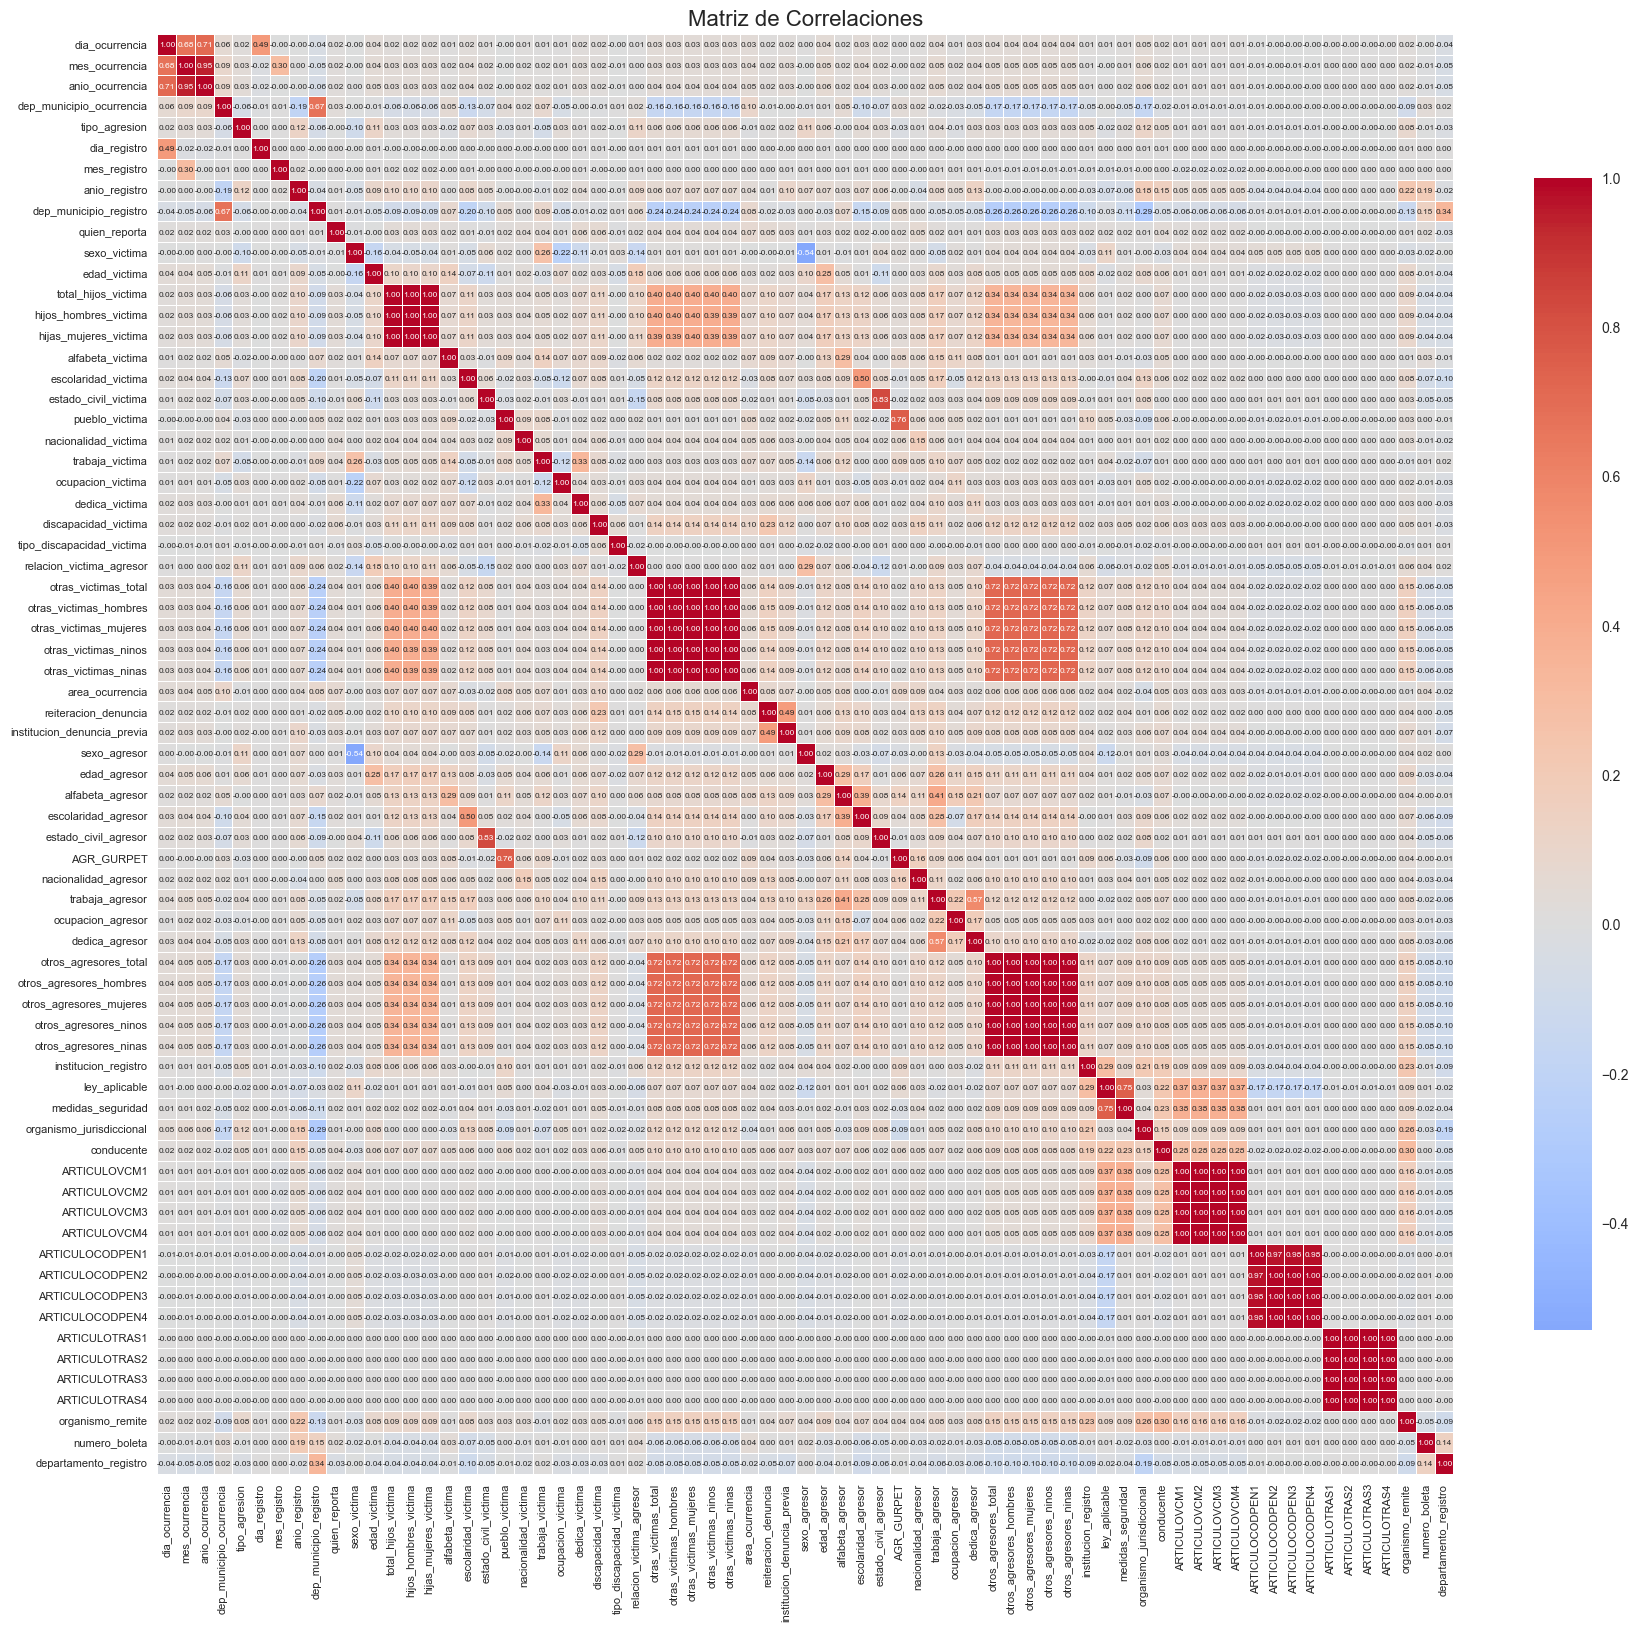

In [ ]:
datos = df[columnas_numericas]
corr_matrix = datos.corr()

# Ajustar el tamaño de la figura según la cantidad de columnas
plt.figure(figsize=(18, 16))

# Crear el heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            cbar_kws={'shrink': 0.8},  
            annot_kws={'size': 6},  # Reducir el tamaño de los números
            linewidths=0.5)

# Rotar etiquetas para mejor visualización
plt.xticks(rotation=90, fontsize=8)  # Rotar y reducir tamaño de etiquetas
plt.yticks(rotation=0, fontsize=8)   # Reducir tamaño de etiquetas en el eje y

# Título y presentación final
plt.title('Matriz de Correlaciones', fontsize=16)
plt.tight_layout()

# Ajuste de márgenes si es necesario
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Mostrar la gráfica
plt.show()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(datos)
X_scaled = pd.DataFrame(X_scaled, columns=datos.columns)

- Resumen de las variables numéricas


📊 Estadísticas descriptivas — Variables numéricas


count         mean          std     min     25%  \
dep_municipio_ocurrencia  328959.0   888.149076   848.898045     1.0   115.0   
tipo_agresion             328959.0  1612.877264   491.062758  1111.0  1122.0   
dep_municipio_registro    328959.0   958.244632   656.962671   101.0   309.0   
quien_reporta             328959.0     1.122678     0.873304     1.0     1.0   
sexo_victima              328959.0     1.874921     0.330809     1.0     2.0   
...                            ...          ...          ...     ...     ...   
ARTICULOTRAS3             328959.0   998.984816     3.894726     0.0   999.0   
ARTICULOTRAS4             328959.0   998.984816     3.894726     0.0   999.0   
organismo_remite          328959.0    26.576531    26.028270     1.0    18.0   
numero_boleta             328959.0   419.492590  1895.502808     0.0    95.0   
departamento_registro     328959.0     8.970185     2.241568     1.0     9.0   

                             50%     75%      max  
dep_municipio_ocurrencia   903.0  1504.0   9999.0  
tipo_agresion             1222.0  2122.0   2221.0  
dep_municipio_registro    1003.0  1601.0   2217.0  
quien_reporta                1.0     1.0      9.0  
sexo_victima                 2.0     2.0      2.0  
...                          ...     ...      ...  
ARTICULOTRAS3              999.0   999.0    999.0  
ARTICULOTRAS4              999.0   999.0    999.0  
organismo_remite            18.0    18.0     99.0  
numero_boleta               95.0    95.0  17020.0  
departamento_registro        9.0     9.0     22.0  

[63 rows x 8 columns]


🔬 Prueba de normalidad (Shapiro–Wilk)
dep_municipio_ocurrencia: W=0.7391, p=0.0000 (No normal)
tipo_agresion: W=0.6681, p=0.0000 (No normal)
dep_municipio_registro: W=0.9226, p=0.0000 (No normal)
quien_reporta: W=0.1207, p=0.0000 (No normal)
sexo_victima: W=0.3876, p=0.0000 (No normal)
edad_victima: W=0.8623, p=0.0000 (No normal)
total_hijos_victima: W=0.5217, p=0.0000 (No normal)
hijos_hombres_victima: W=0.5098, p=0.0000 (No normal)
hijas_mujeres_victima: W=0.5093, p=0.0000 (No normal)
alfabeta_victima: W=0.2628, p=0.0000 (No normal)


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 328959.
  res = hypotest_fun_out(*samples, **kwds)


escolaridad_victima: W=0.8461, p=0.0000 (No normal)
estado_civil_victima: W=0.6971, p=0.0000 (No normal)
pueblo_victima: W=0.5959, p=0.0000 (No normal)
nacionalidad_victima: W=0.0564, p=0.0000 (No normal)
trabaja_victima: W=0.4437, p=0.0000 (No normal)
ocupacion_victima: W=0.6617, p=0.0000 (No normal)
dedica_victima: W=0.1631, p=0.0000 (No normal)
discapacidad_victima: W=0.2118, p=0.0000 (No normal)
tipo_discapacidad_victima: W=0.0390, p=0.0000 (No normal)
relacion_victima_agresor: W=0.7323, p=0.0000 (No normal)
otras_victimas_total: W=0.6302, p=0.0000 (No normal)
otras_victimas_hombres: W=0.6205, p=0.0000 (No normal)
otras_victimas_mujeres: W=0.6214, p=0.0000 (No normal)
otras_victimas_ninos: W=0.6237, p=0.0000 (No normal)
otras_victimas_ninas: W=0.6234, p=0.0000 (No normal)
area_ocurrencia: W=0.4005, p=0.0000 (No normal)
reiteracion_denuncia: W=0.2946, p=0.0000 (No normal)
institucion_denuncia_previa: W=0.3128, p=0.0000 (No normal)
sexo_agresor: W=0.4354, p=0.0000 (No normal)
edad_ag

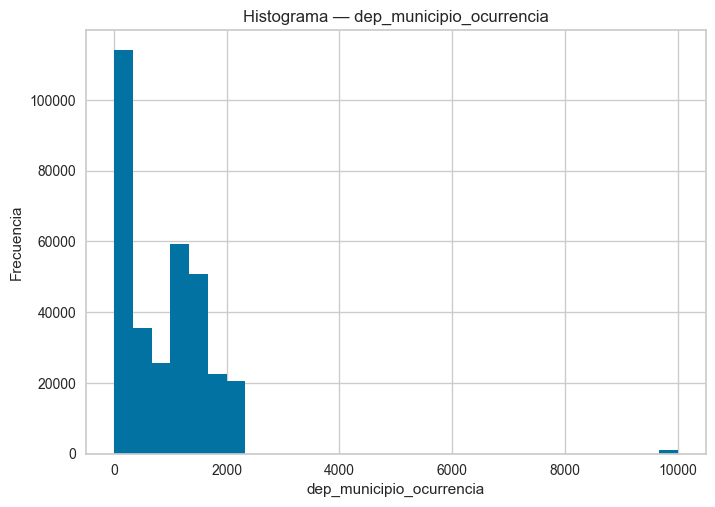

C:\Users\sebas\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


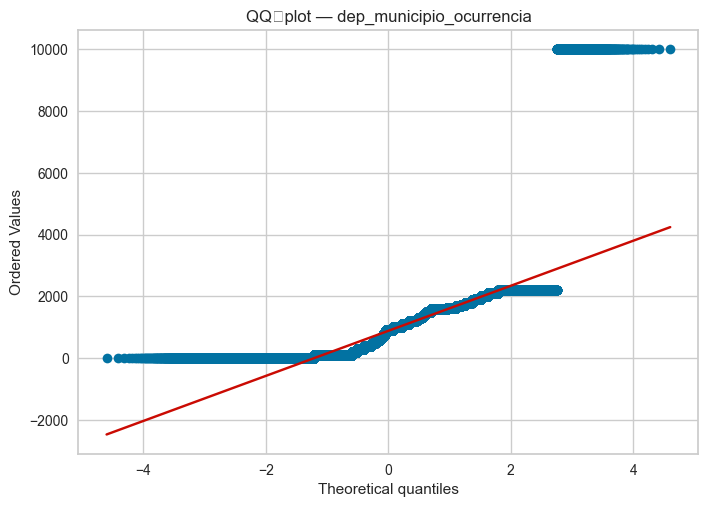

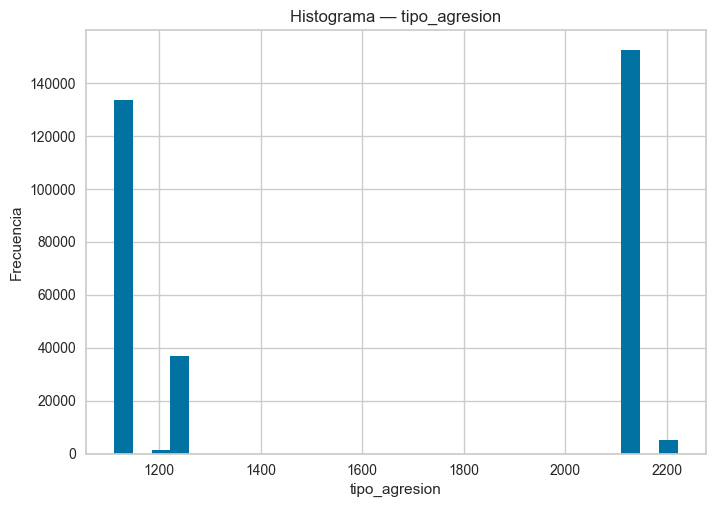

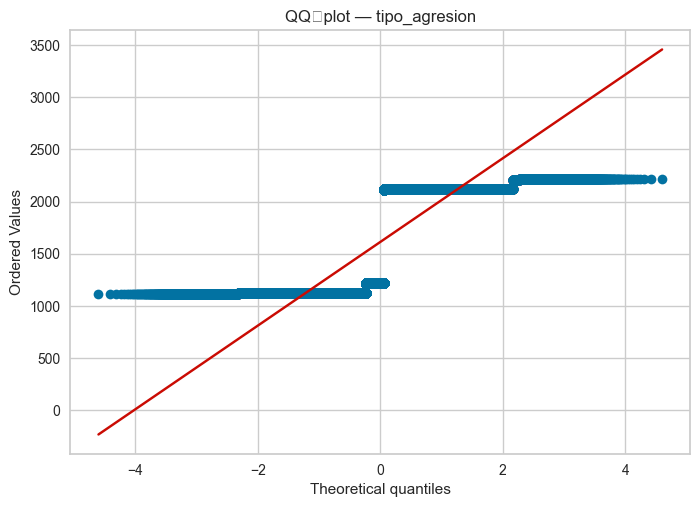

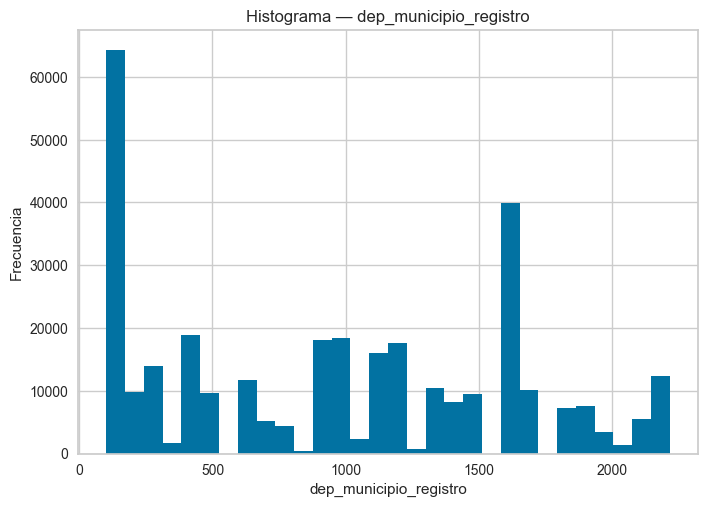

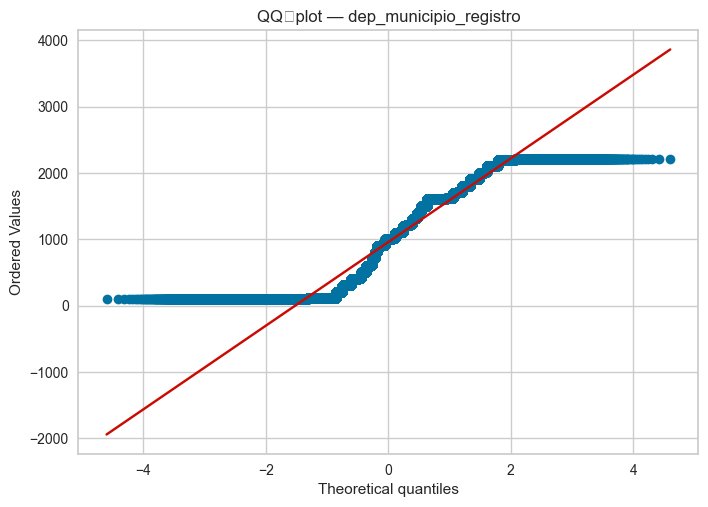

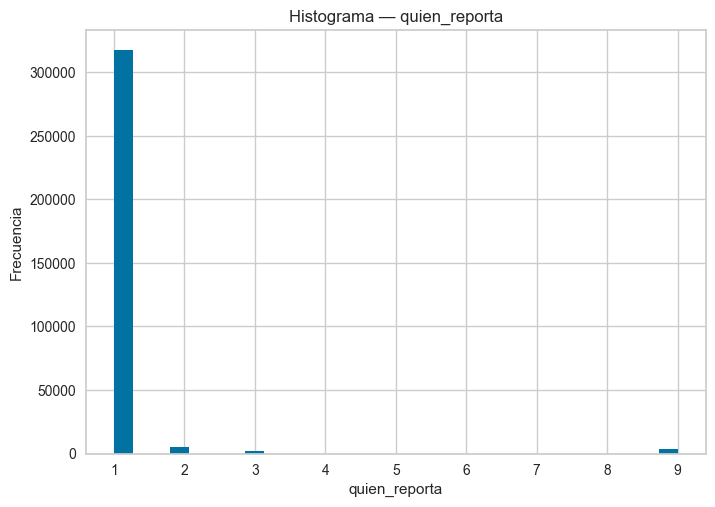

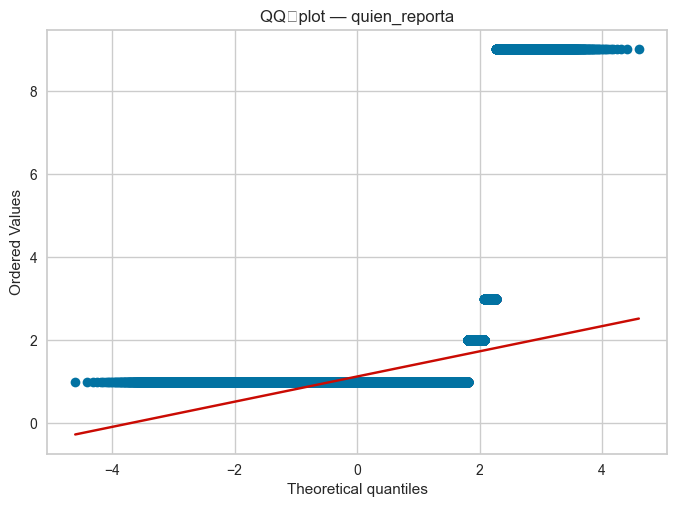

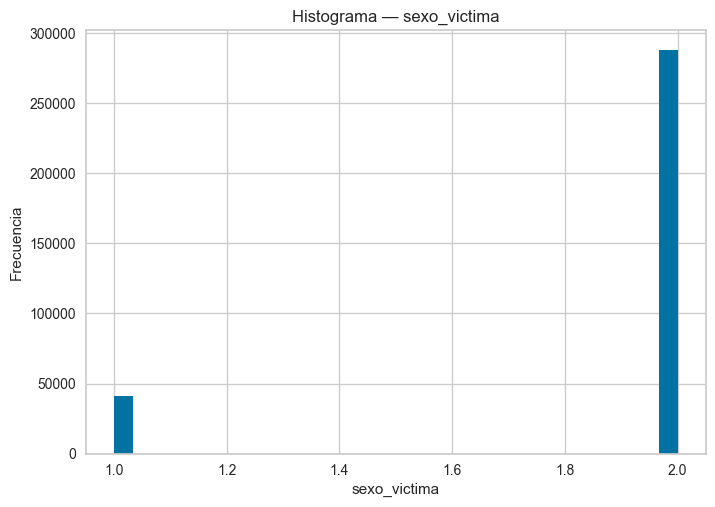

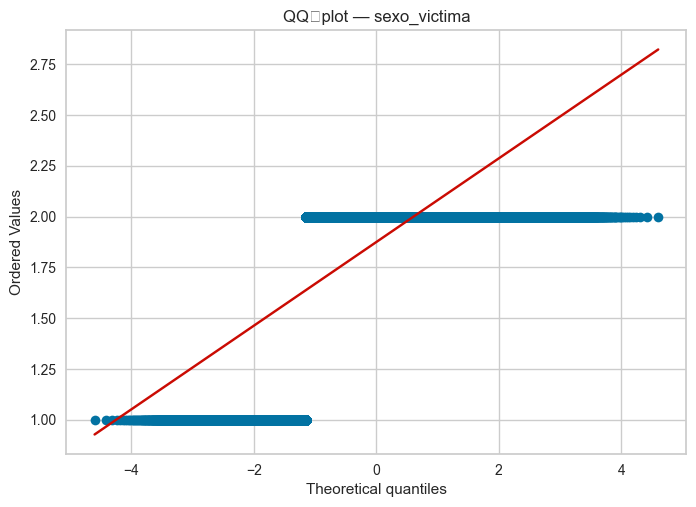

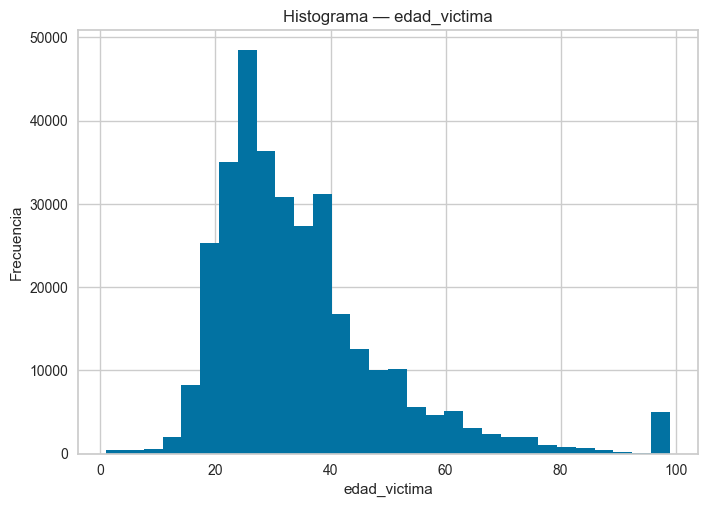

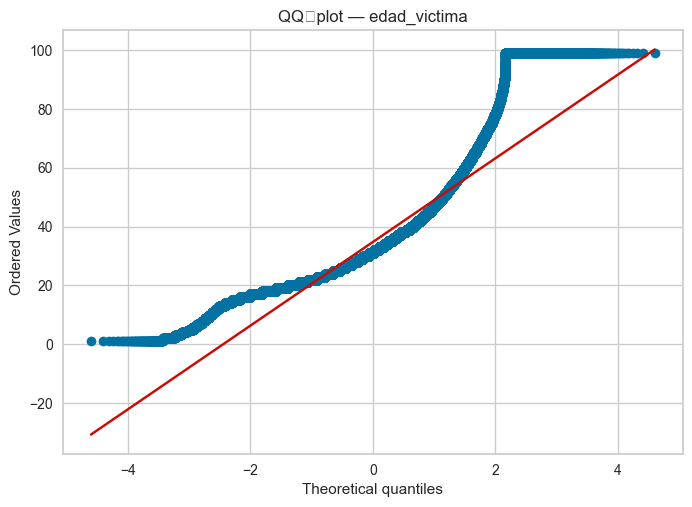

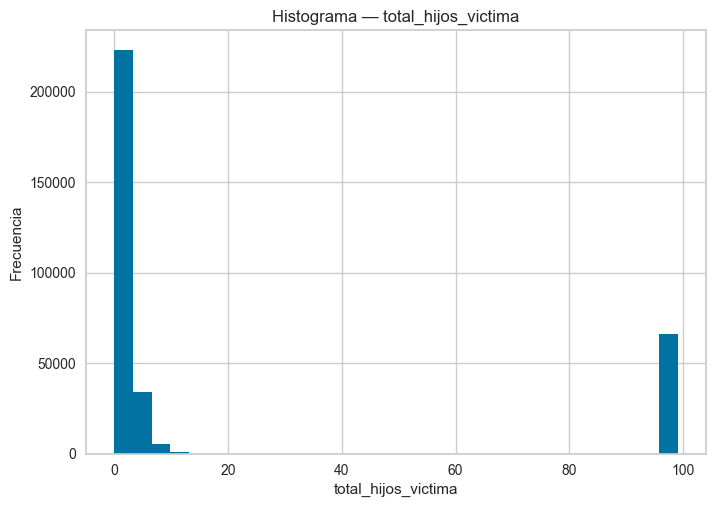

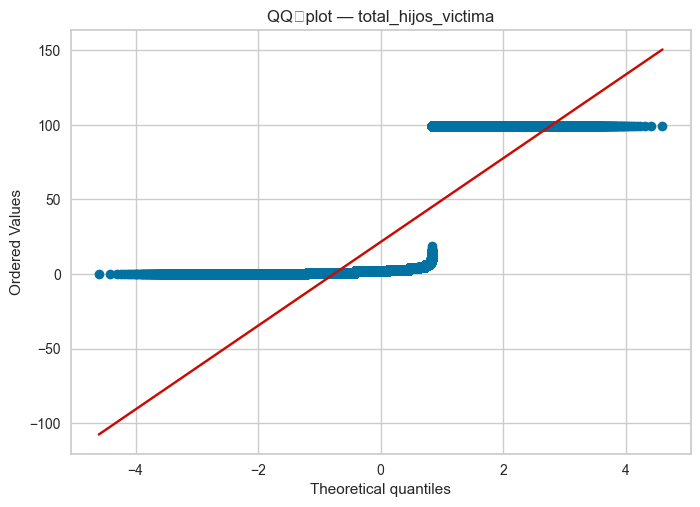

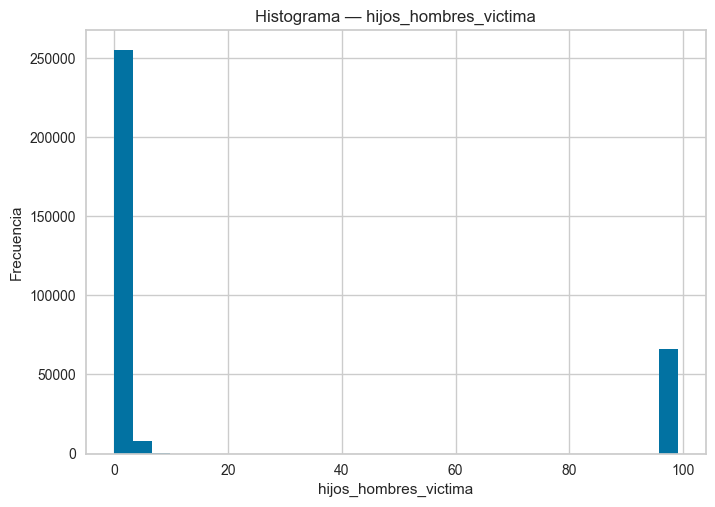

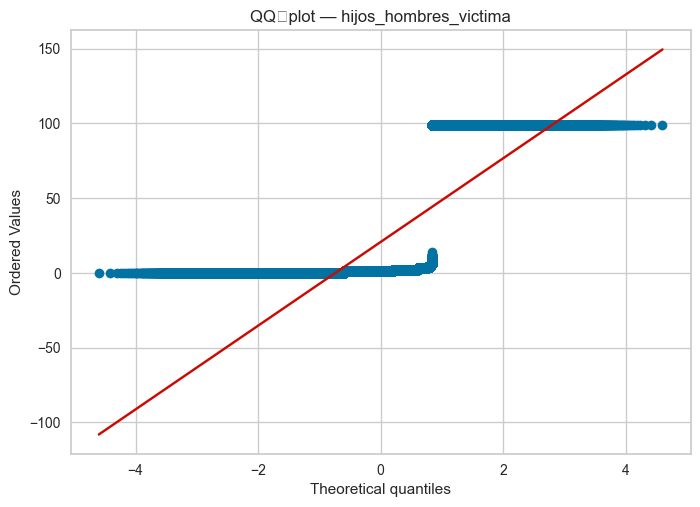

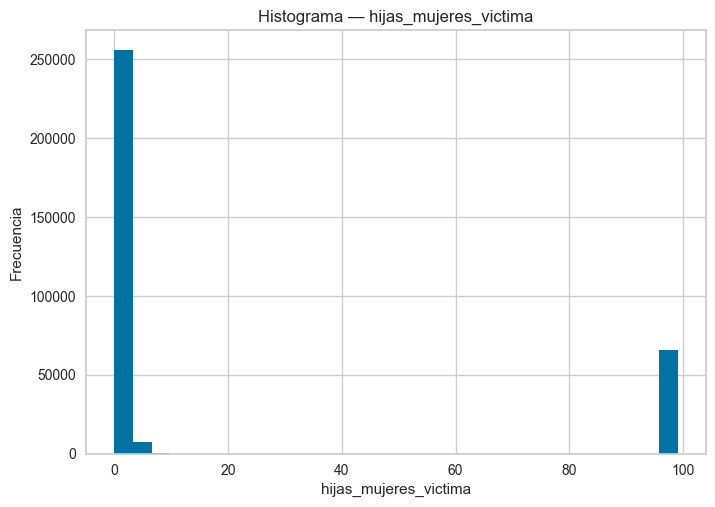

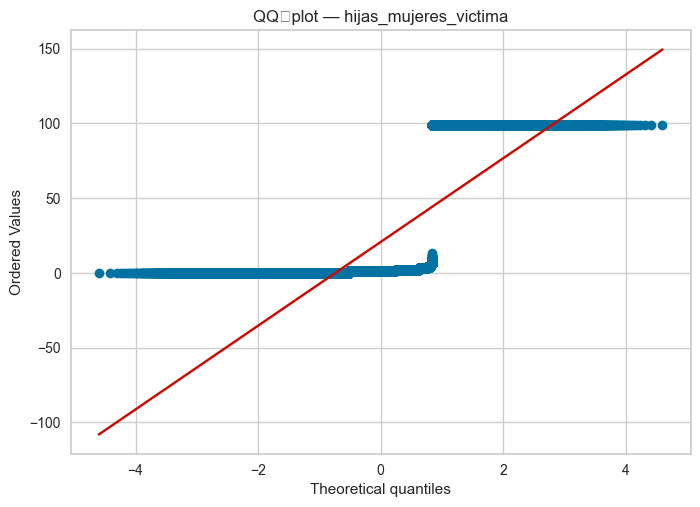

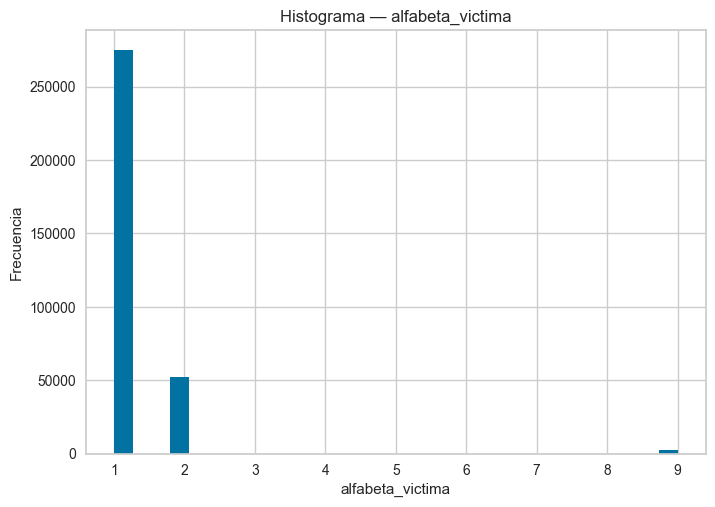

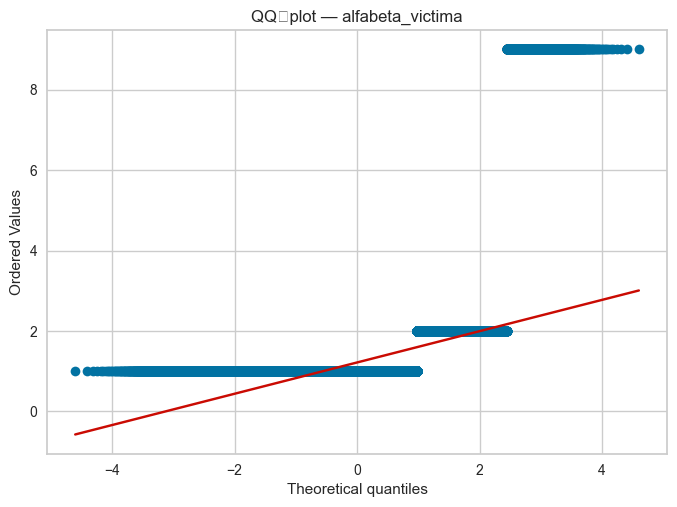

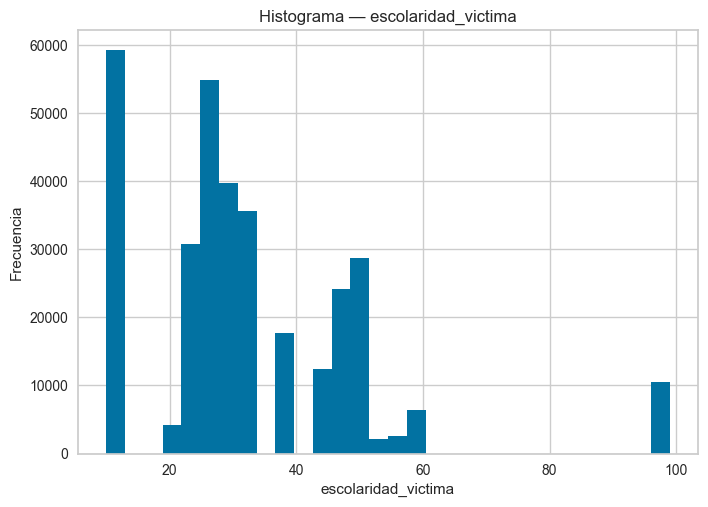

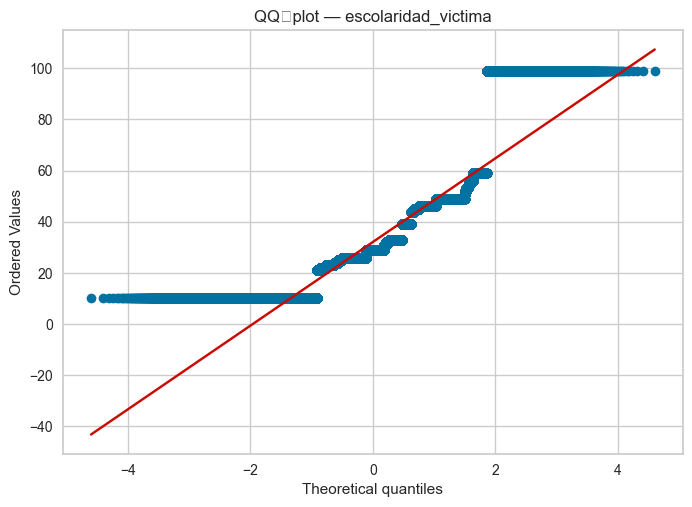

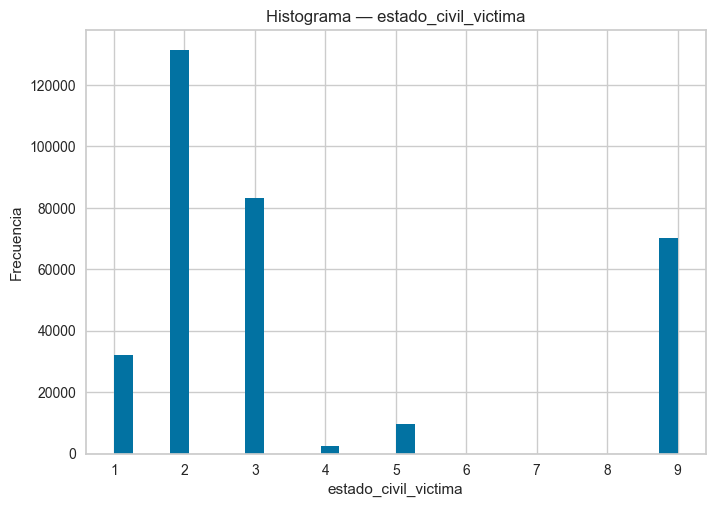

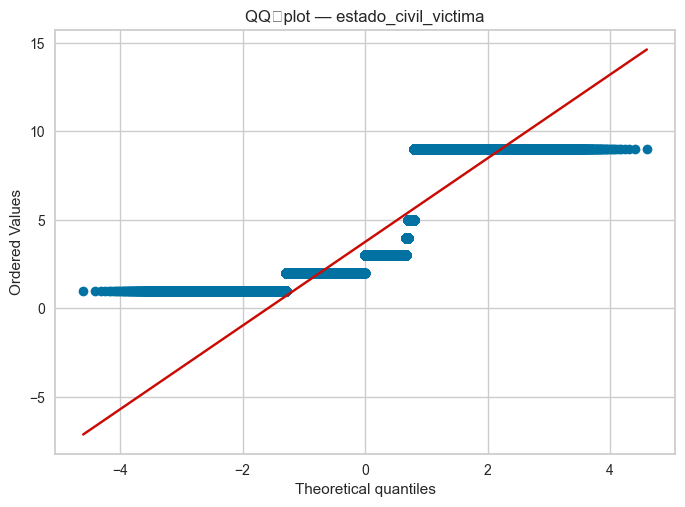

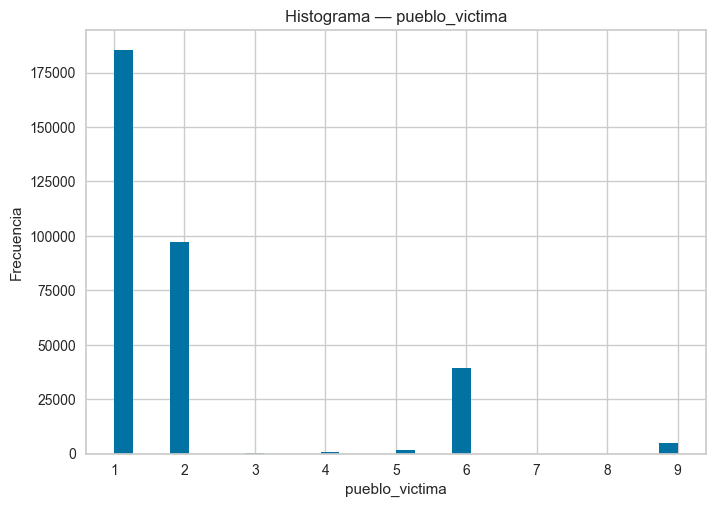

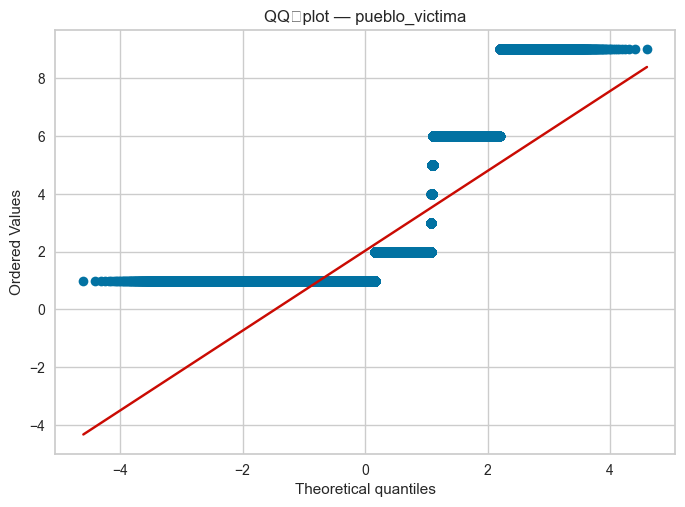

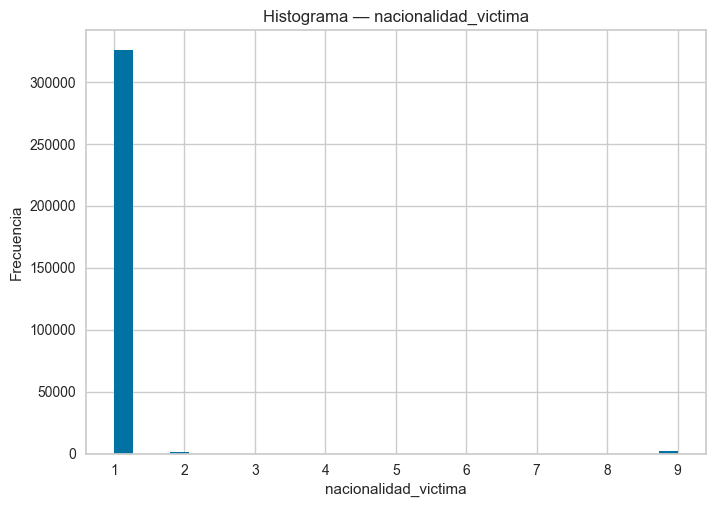

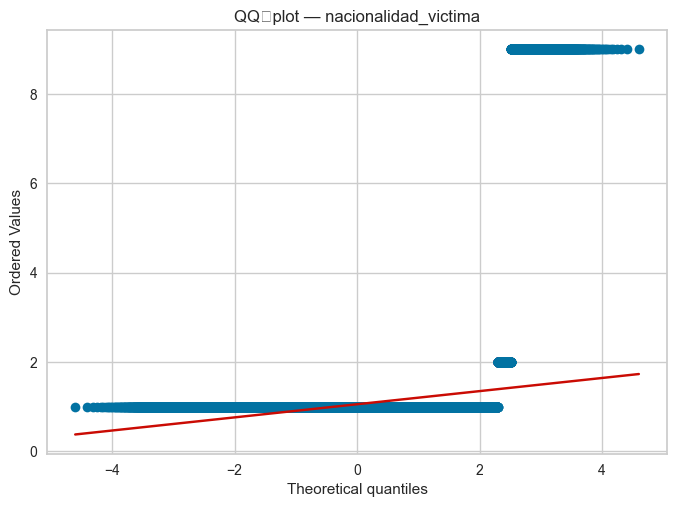

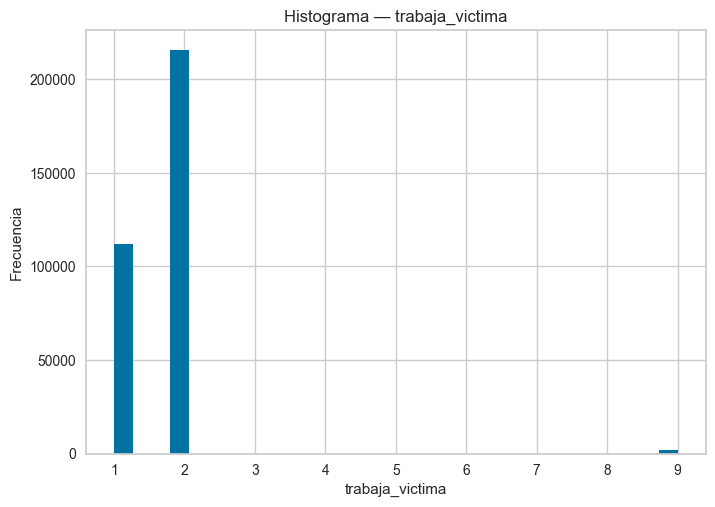

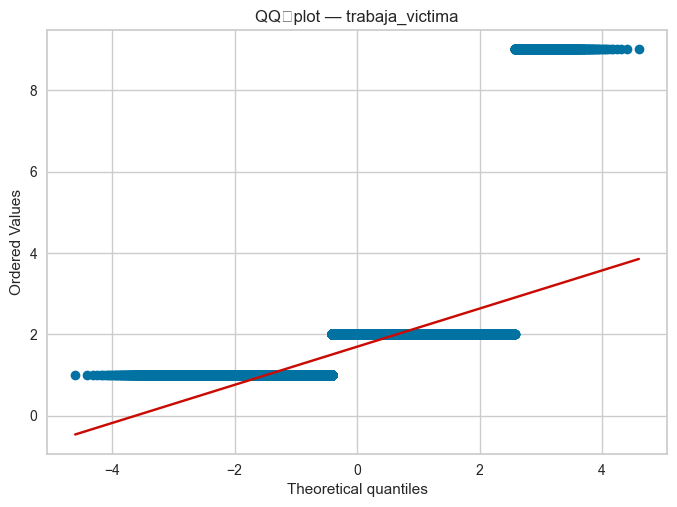

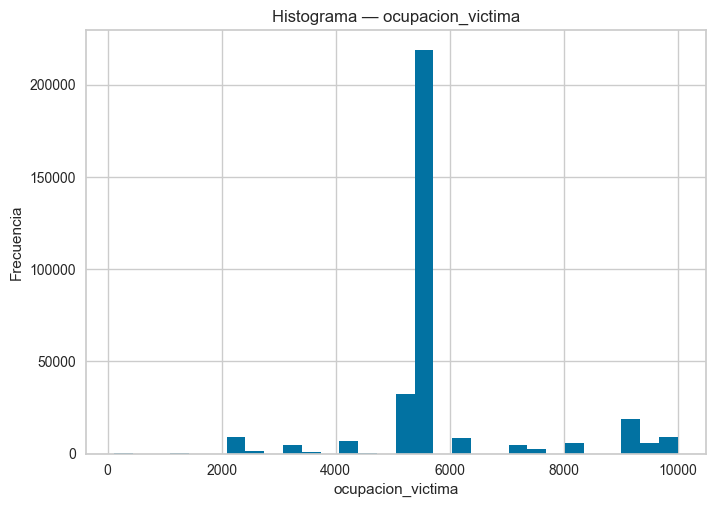

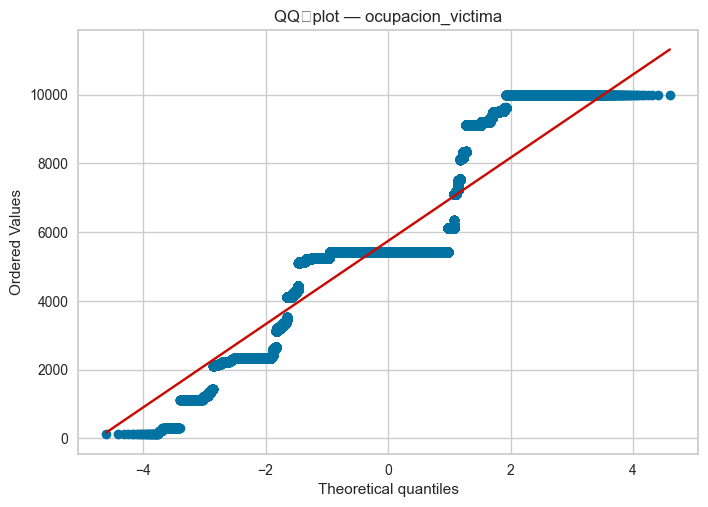

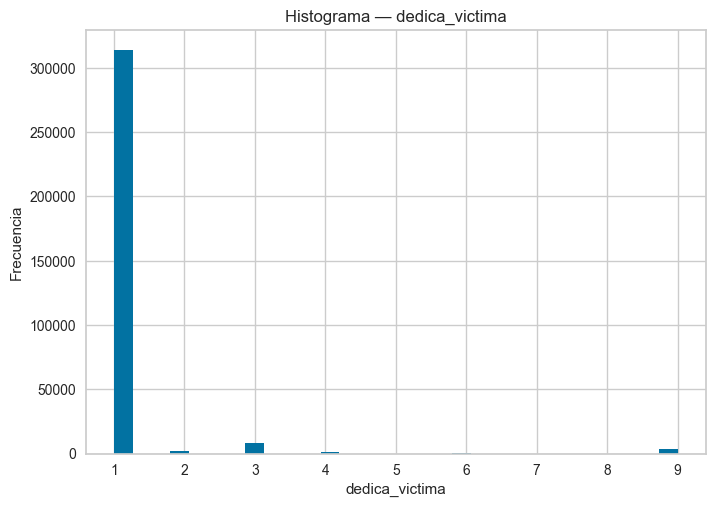

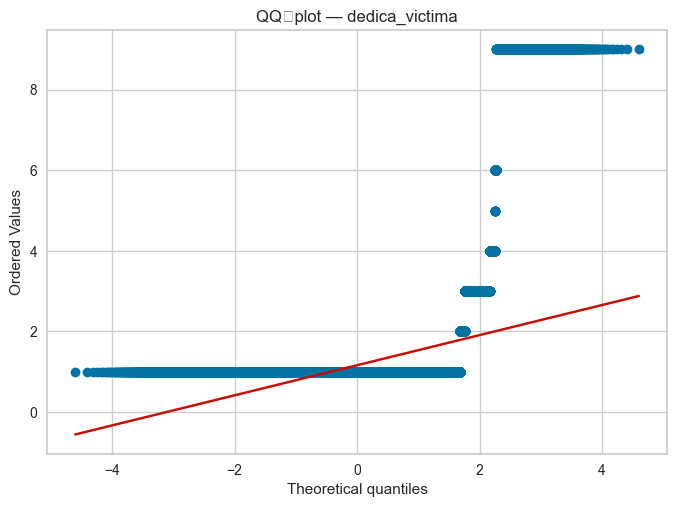

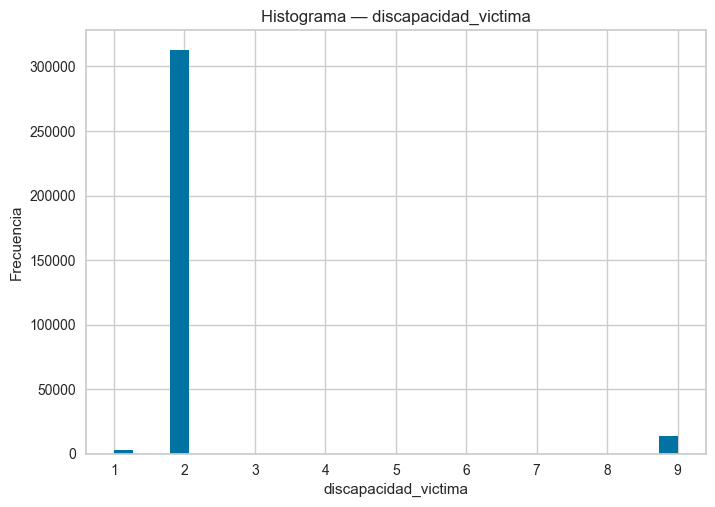

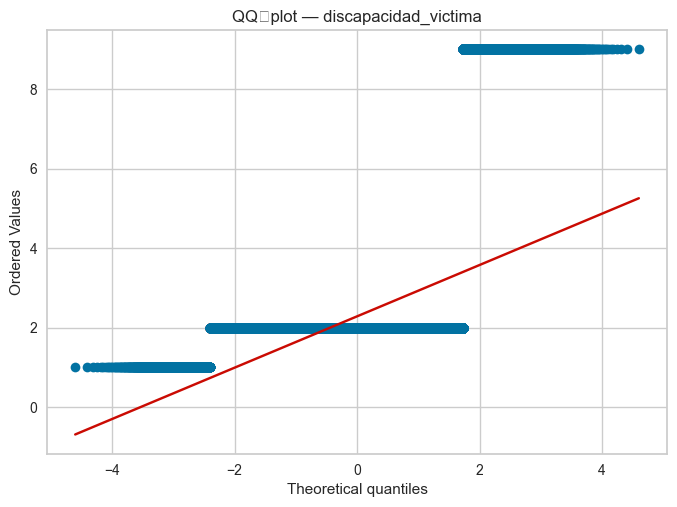

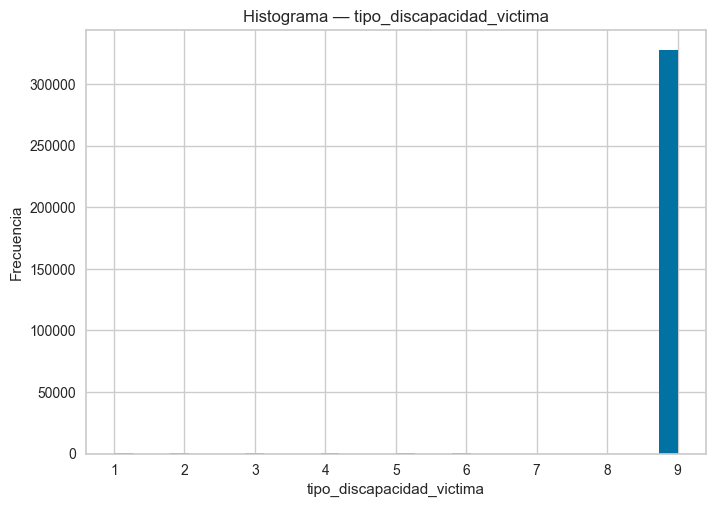

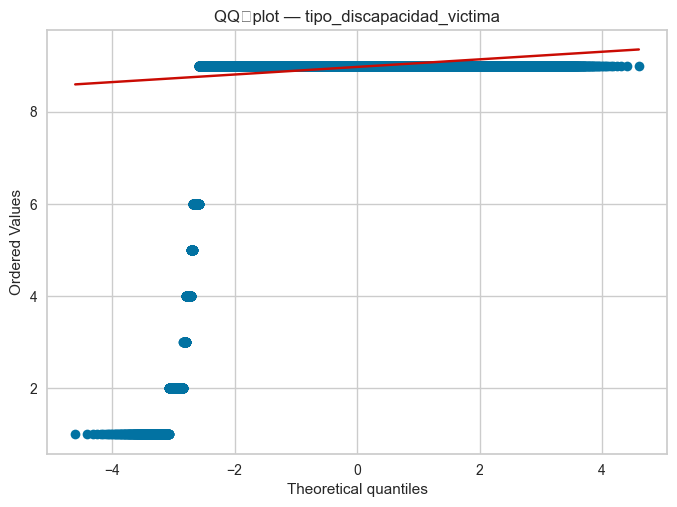

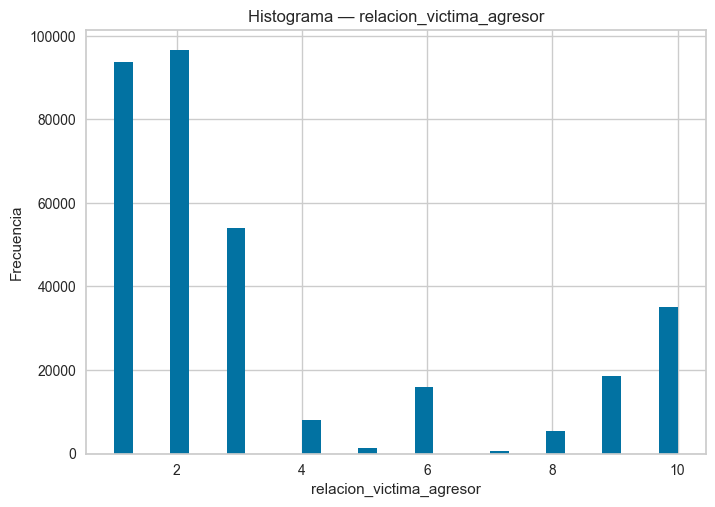

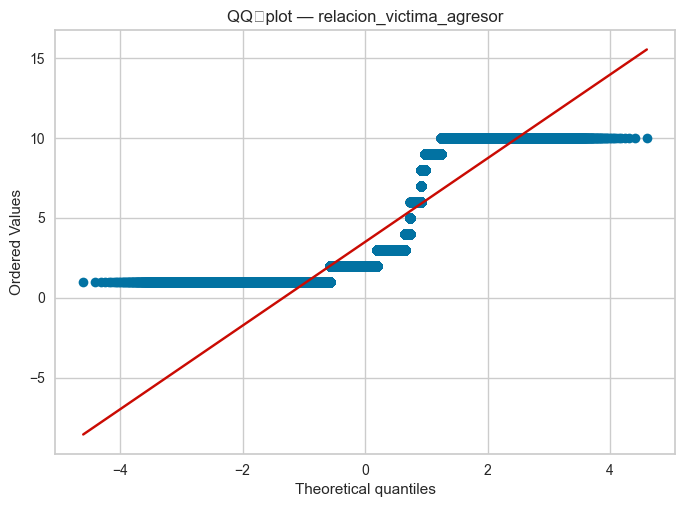

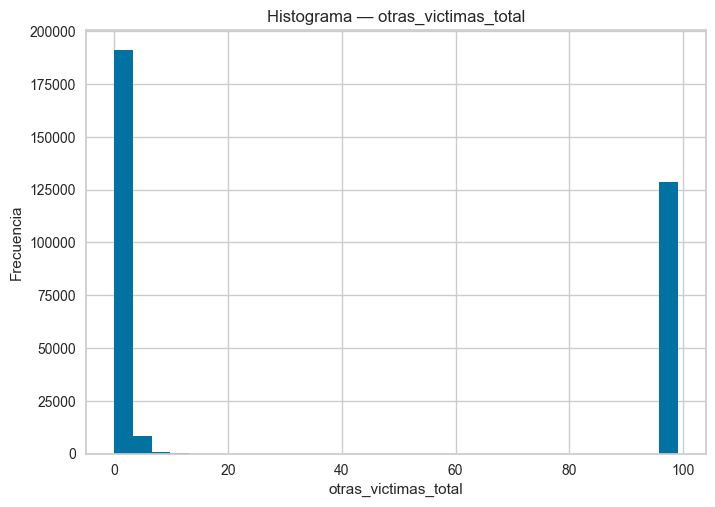

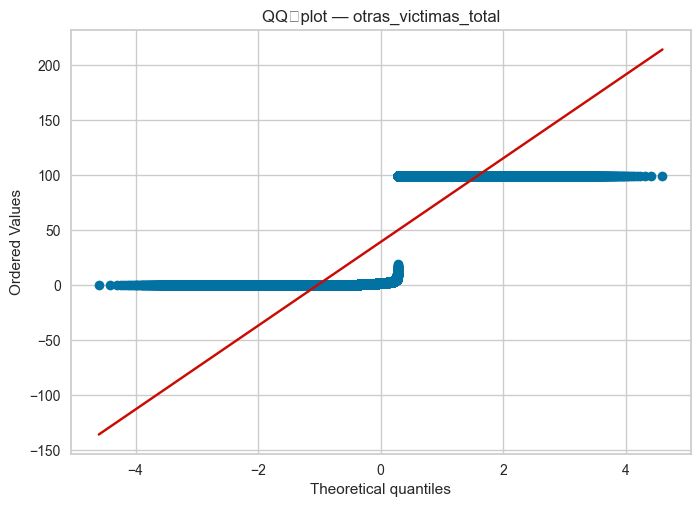

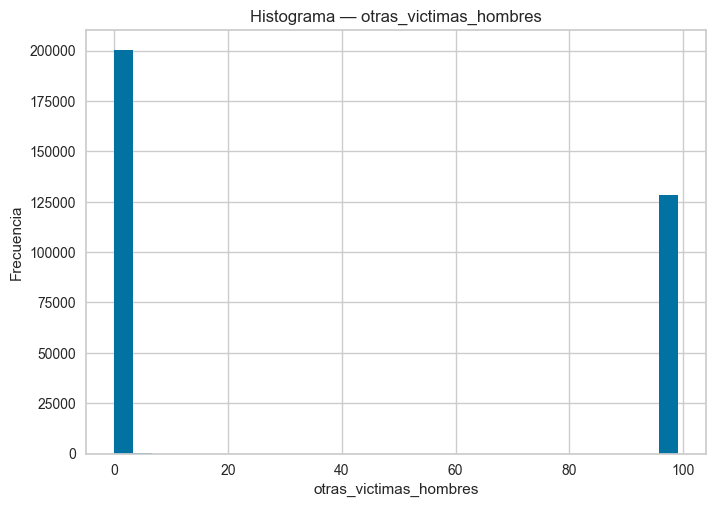

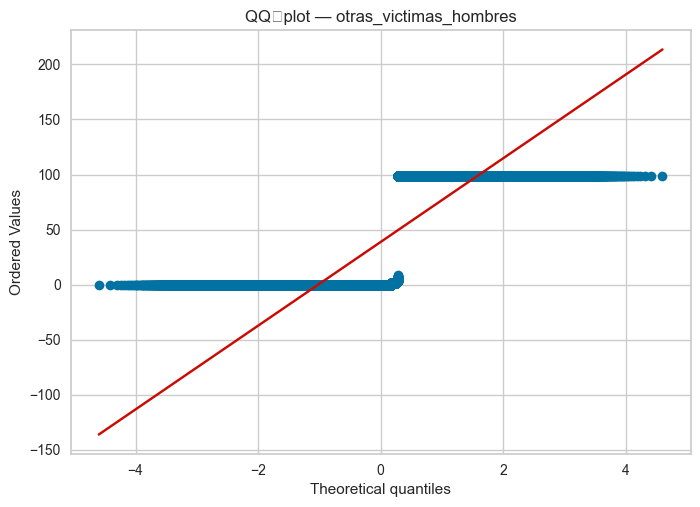

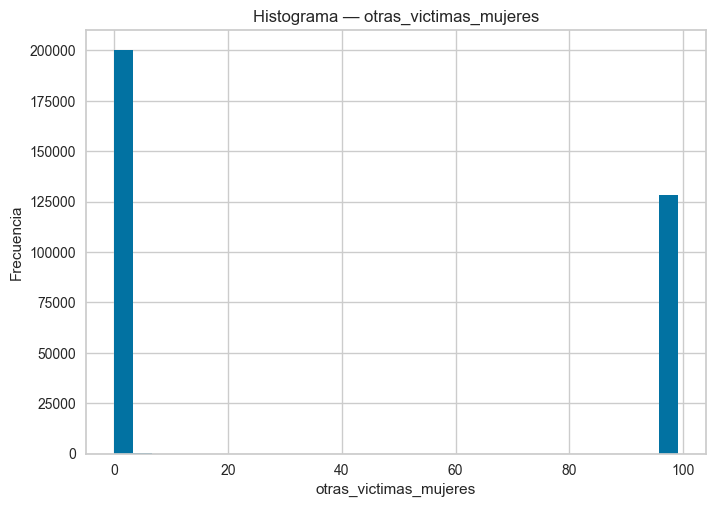

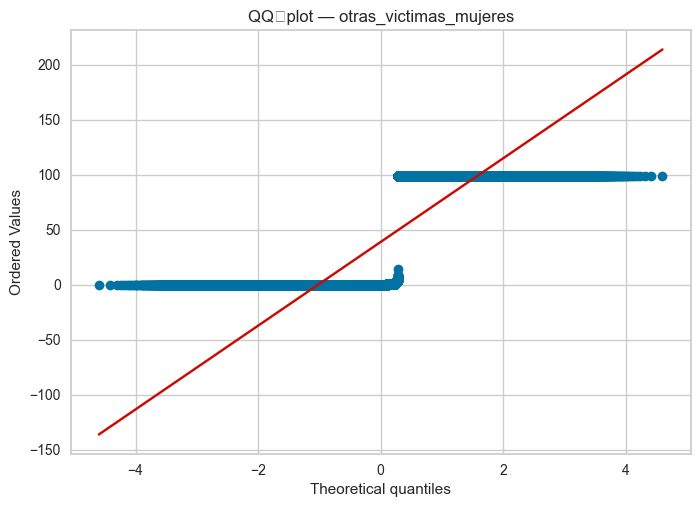

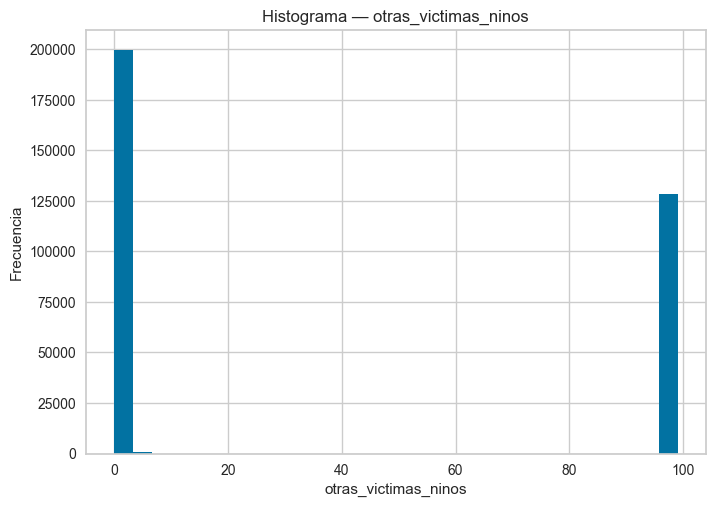

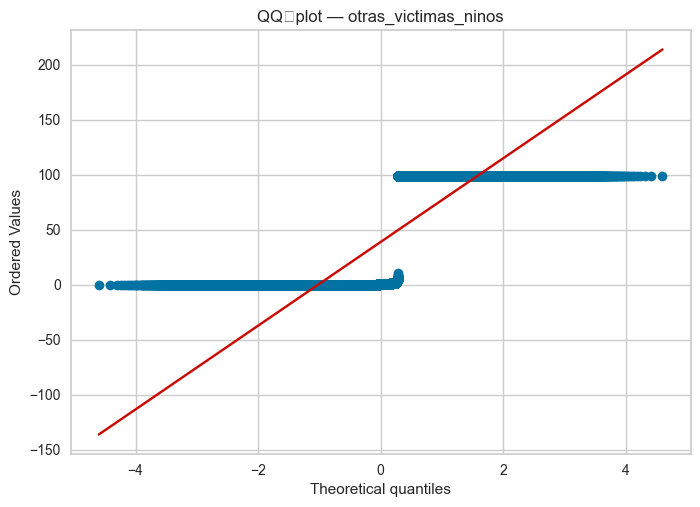

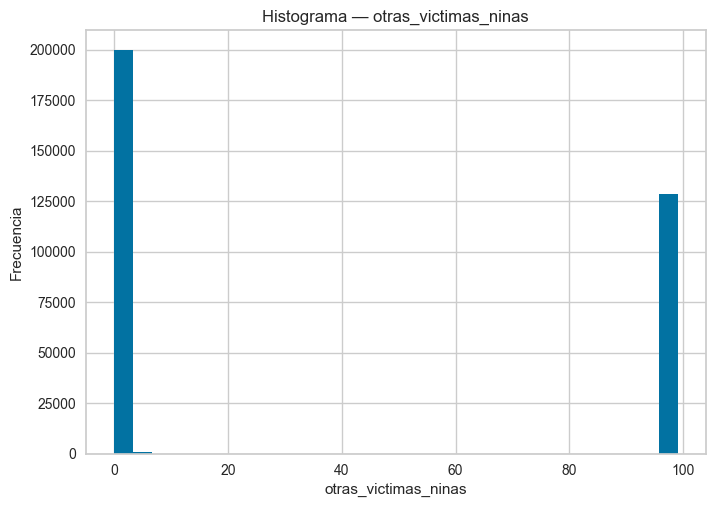

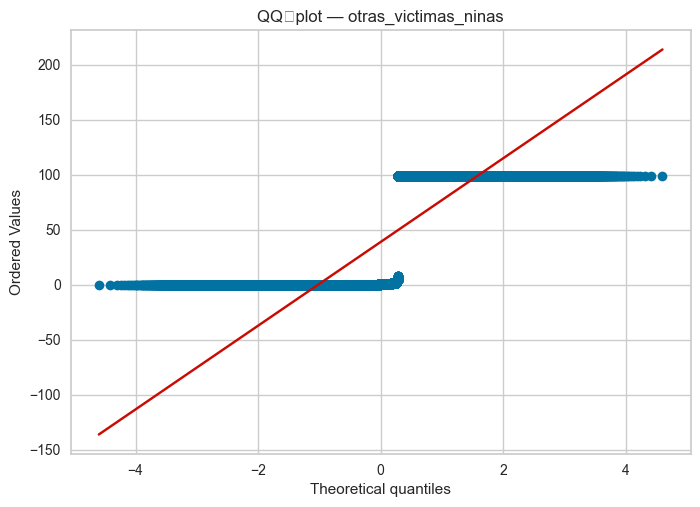

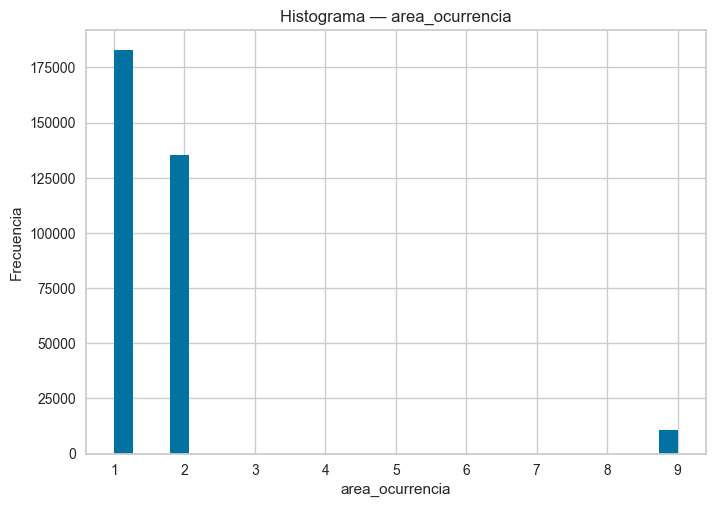

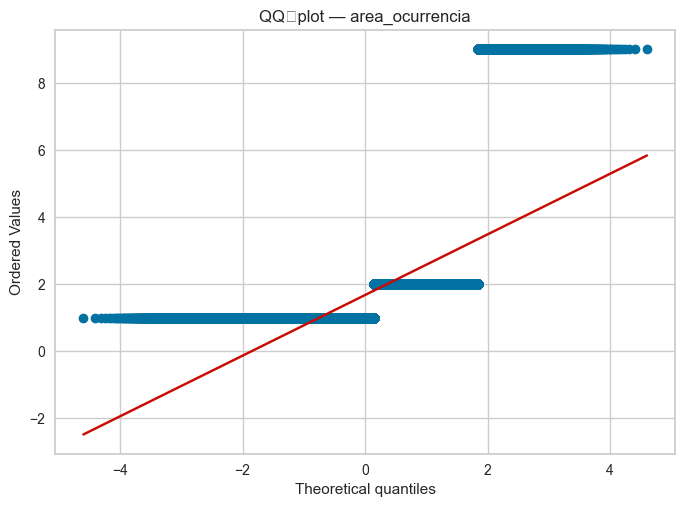

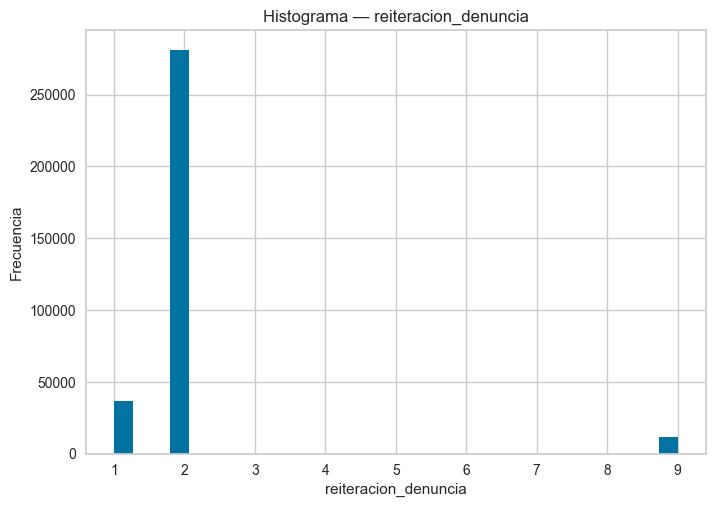

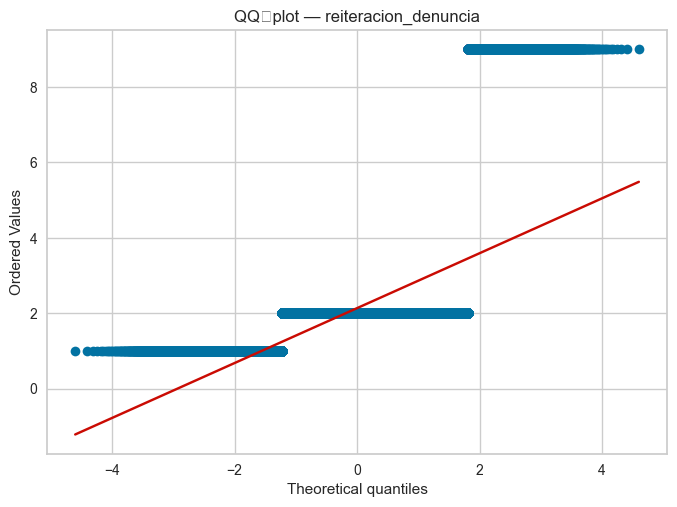

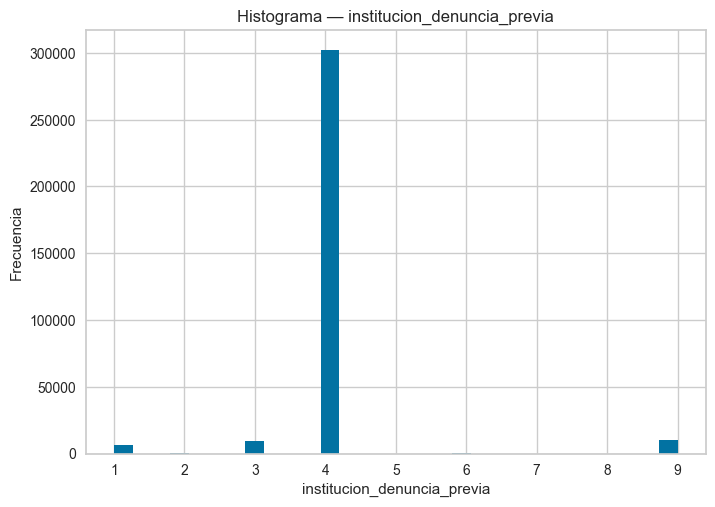

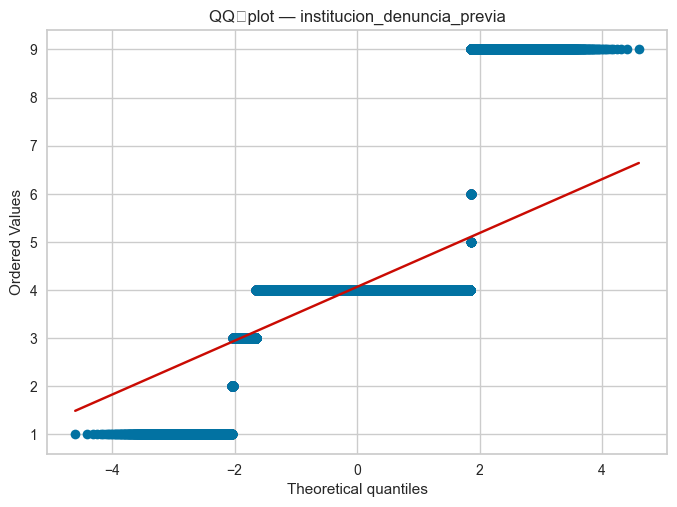

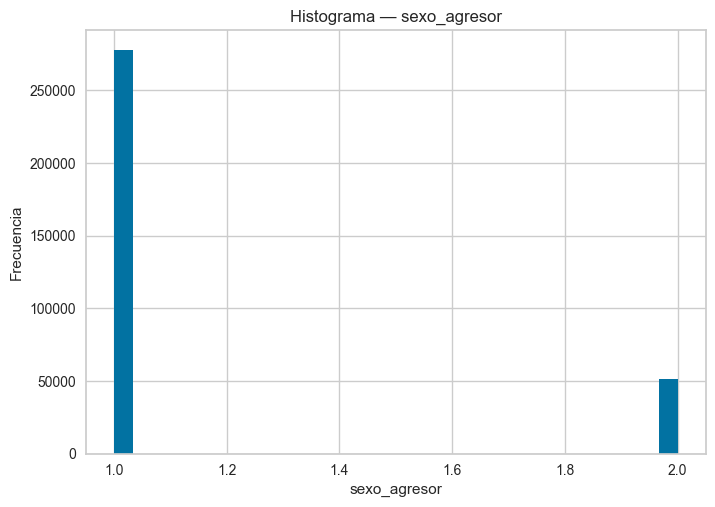

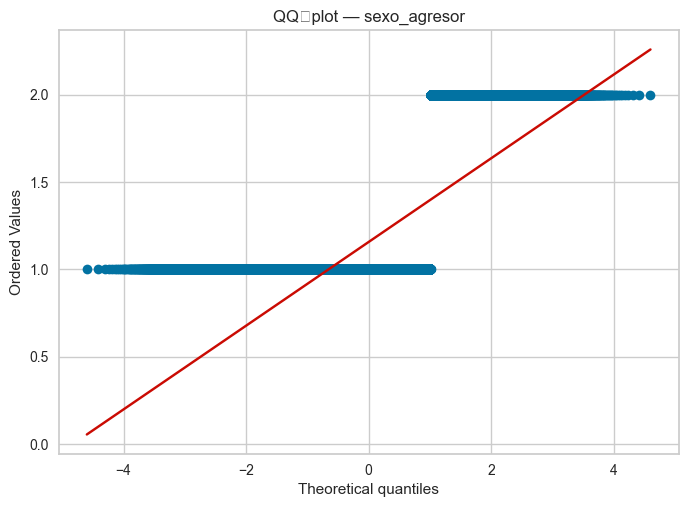

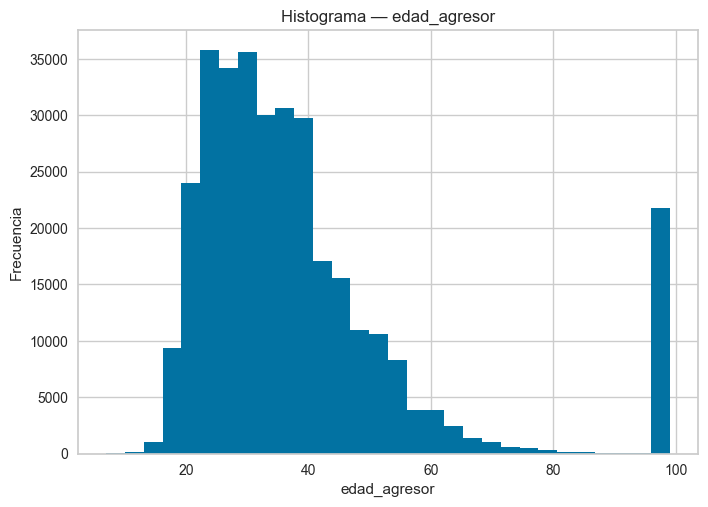

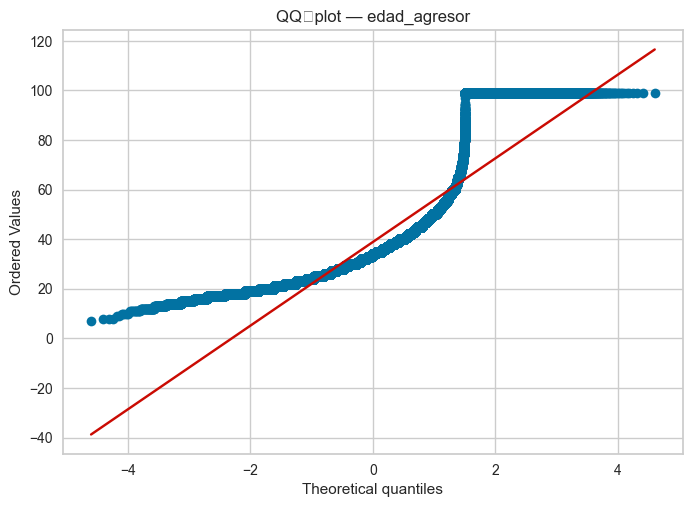

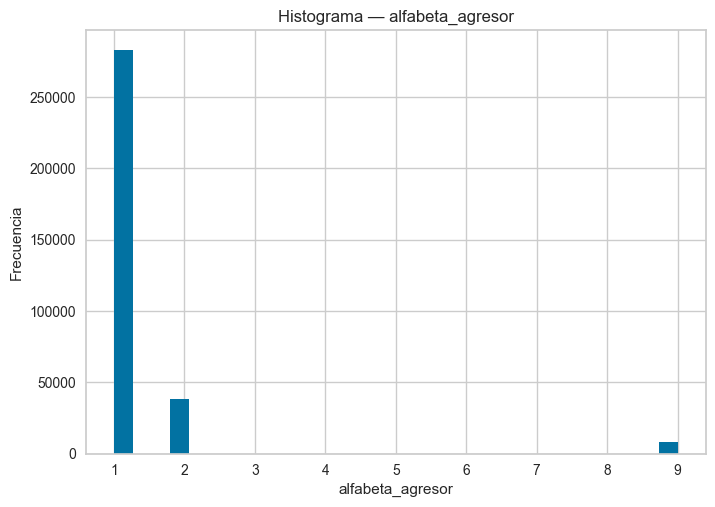

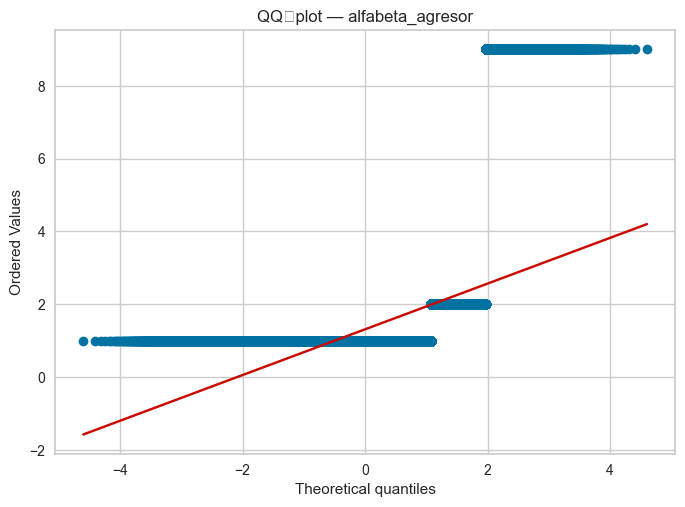

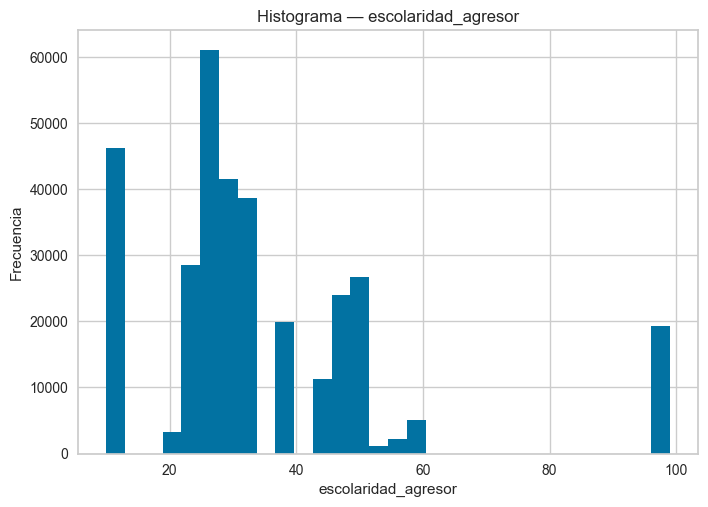

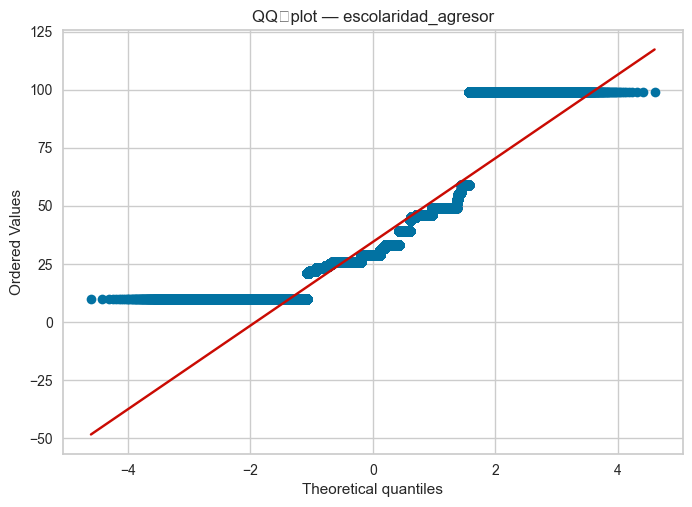

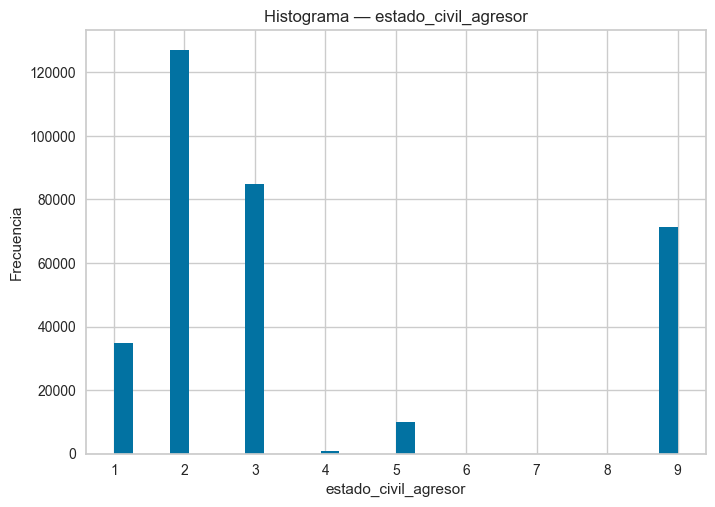

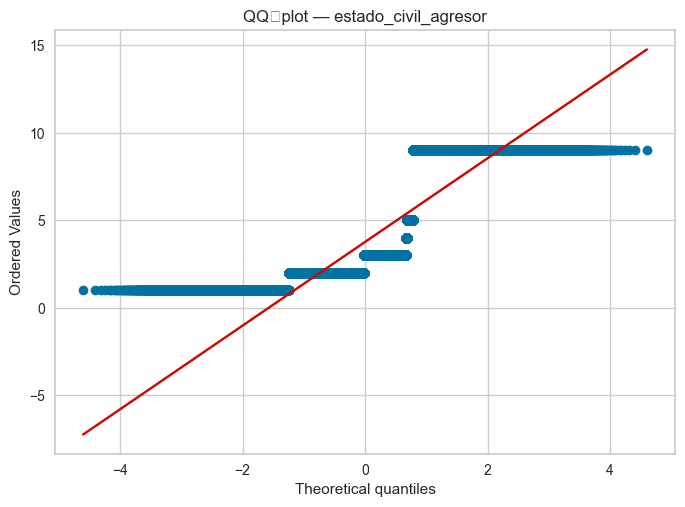

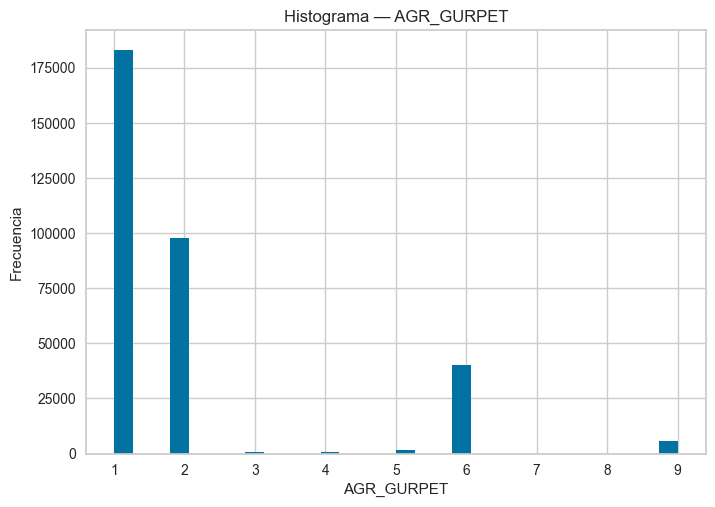

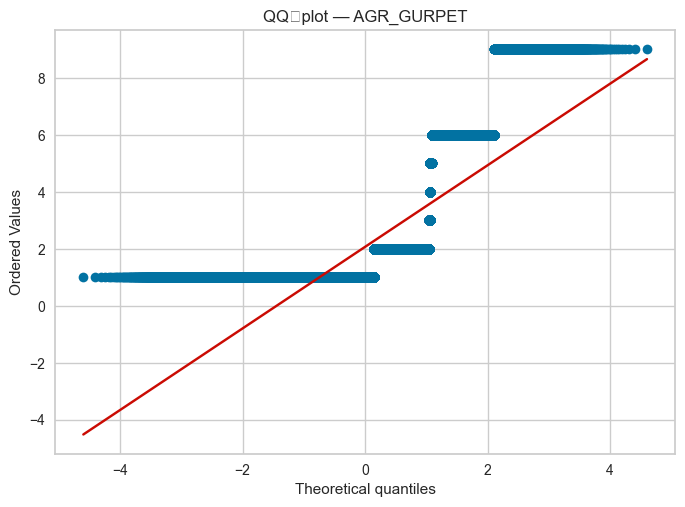

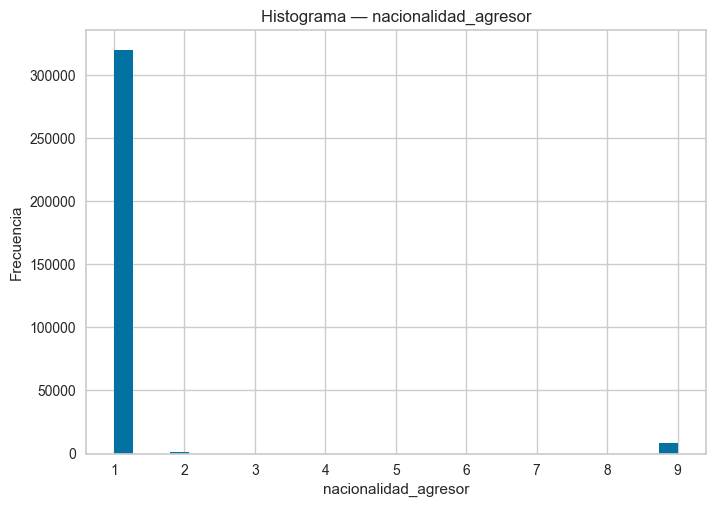

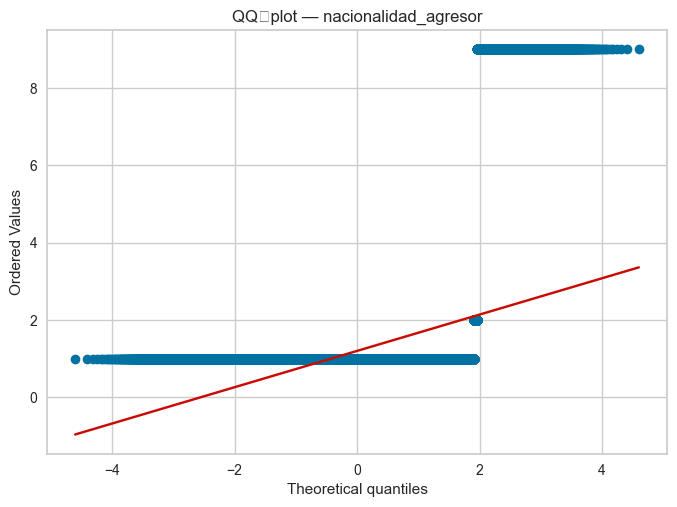

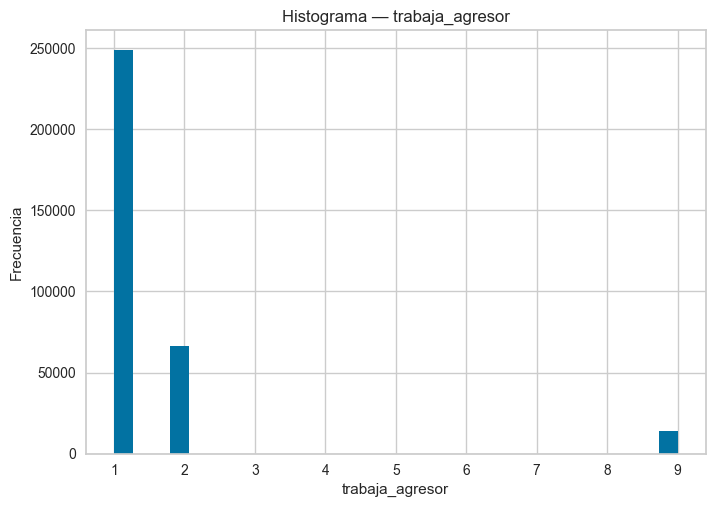

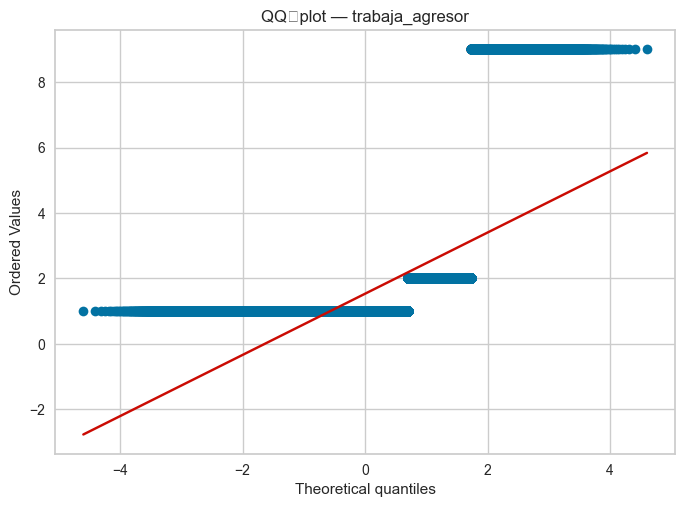

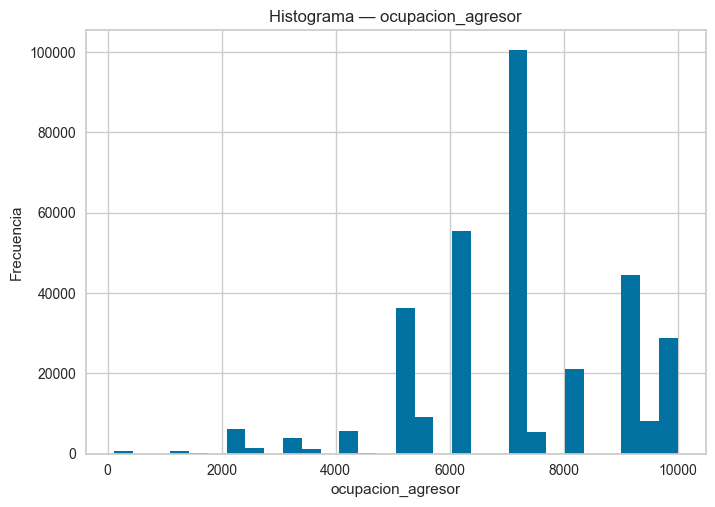

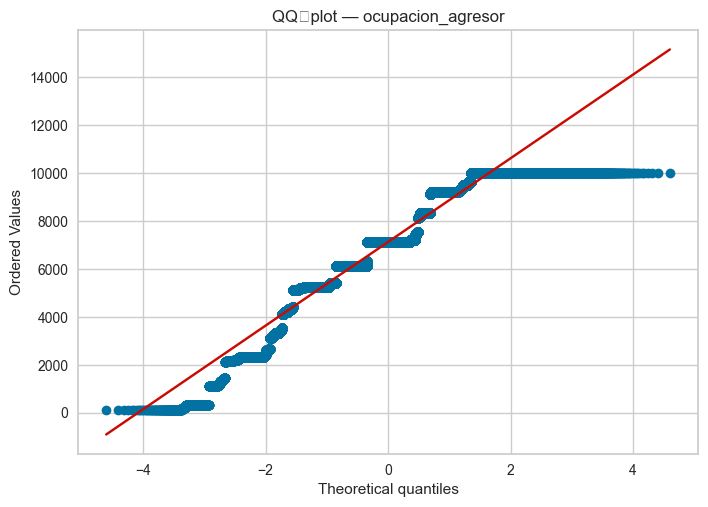

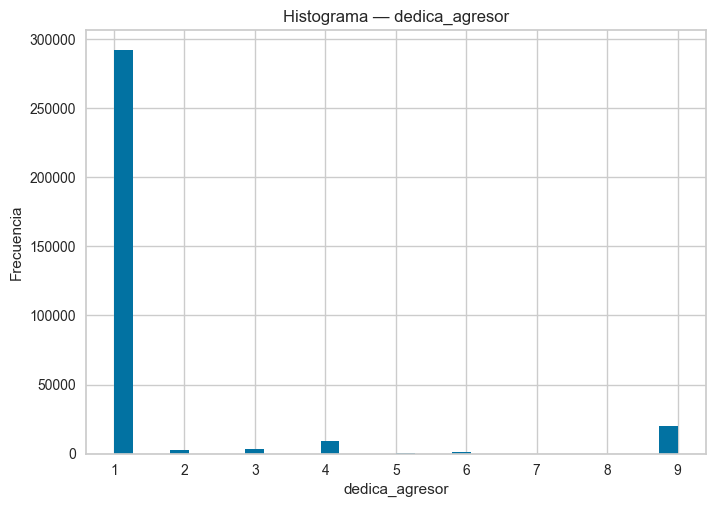

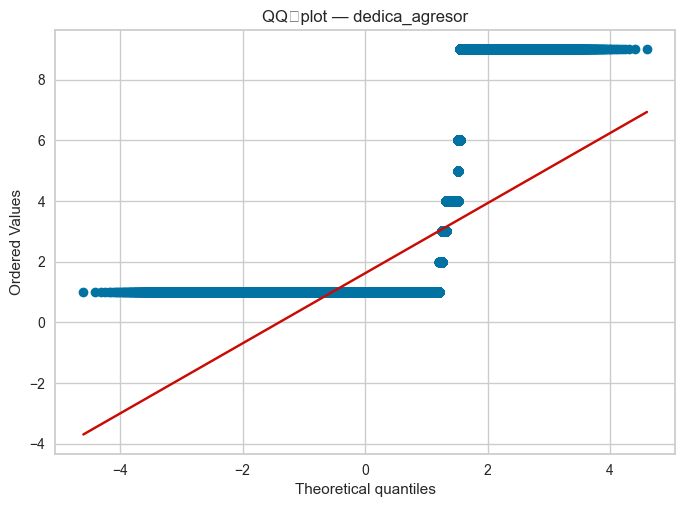

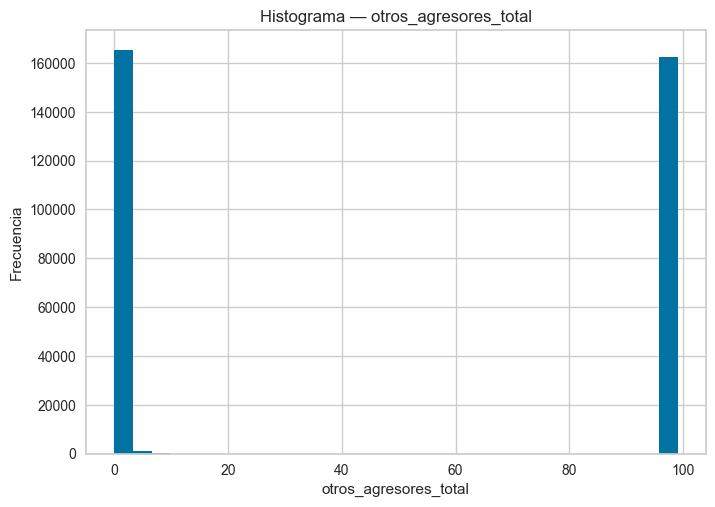

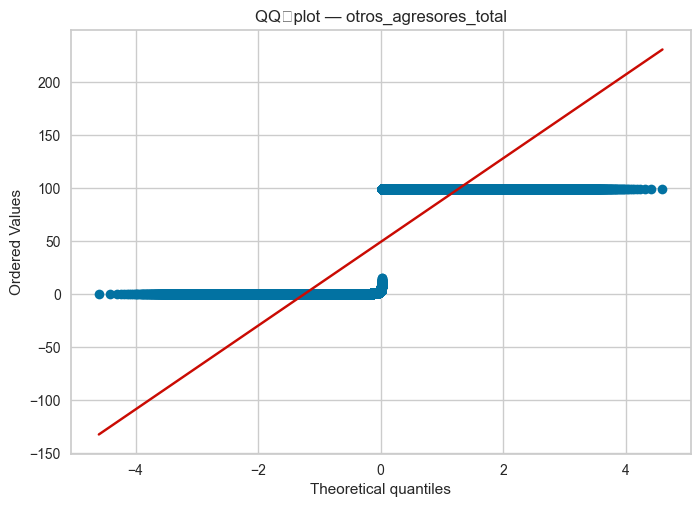

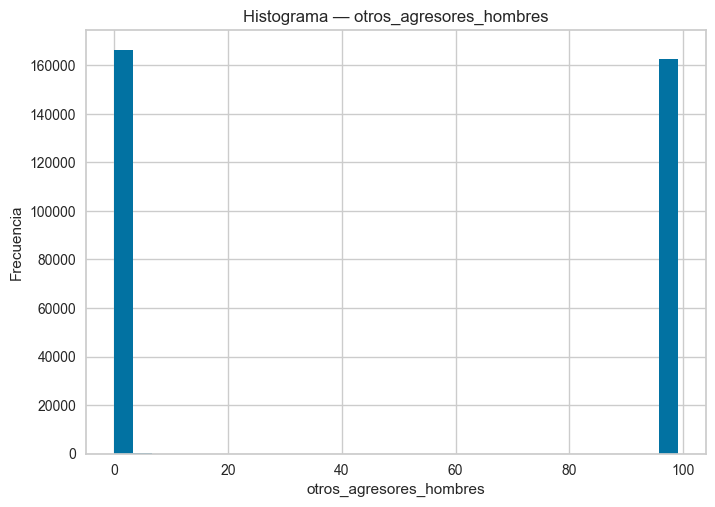

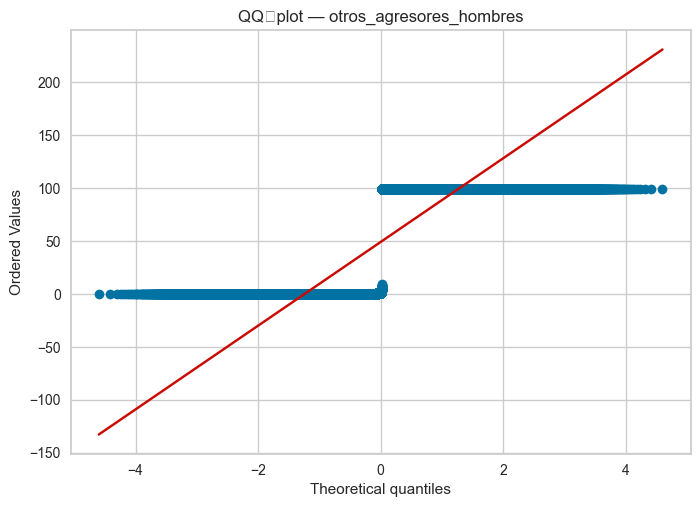

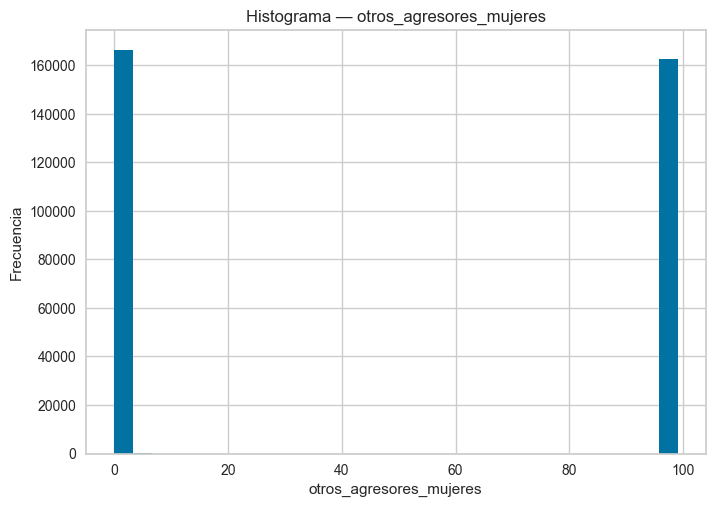

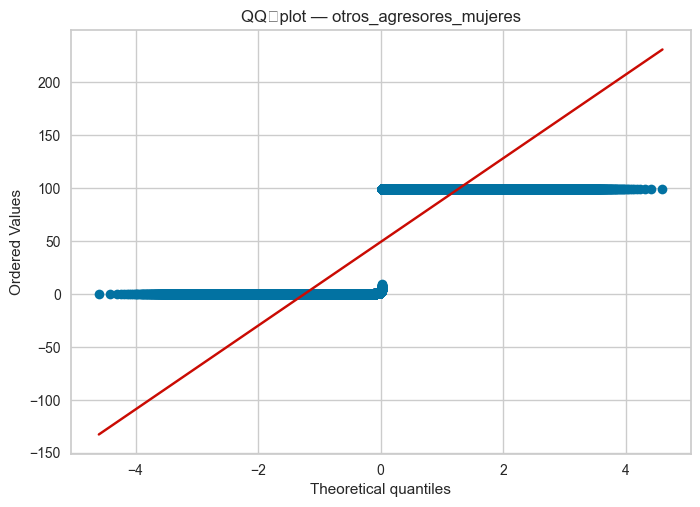

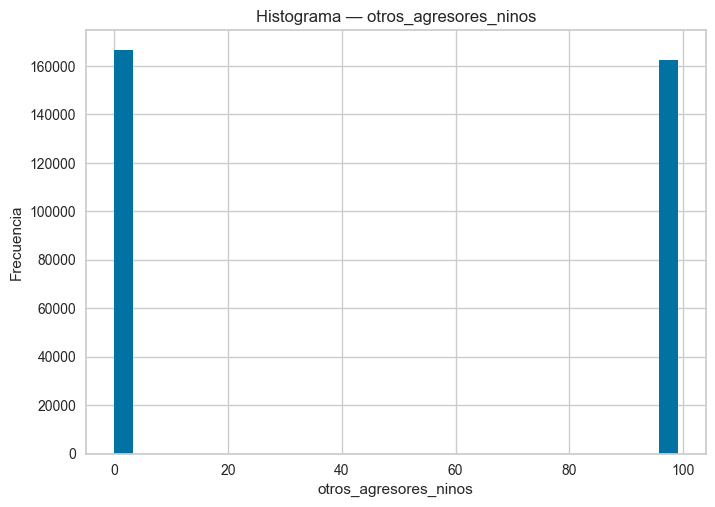

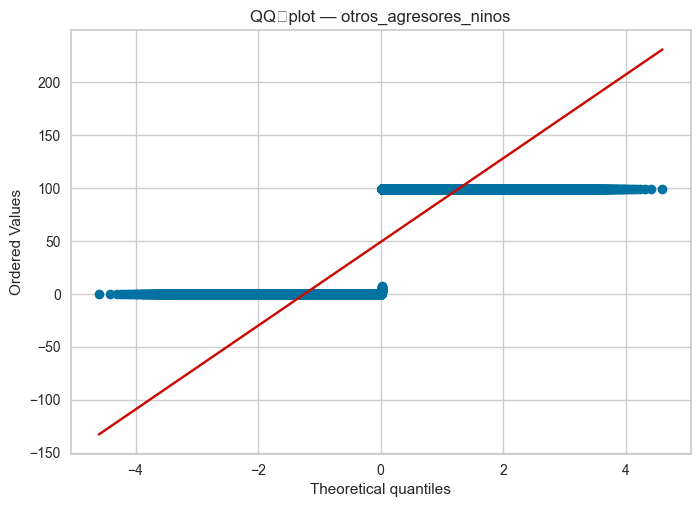

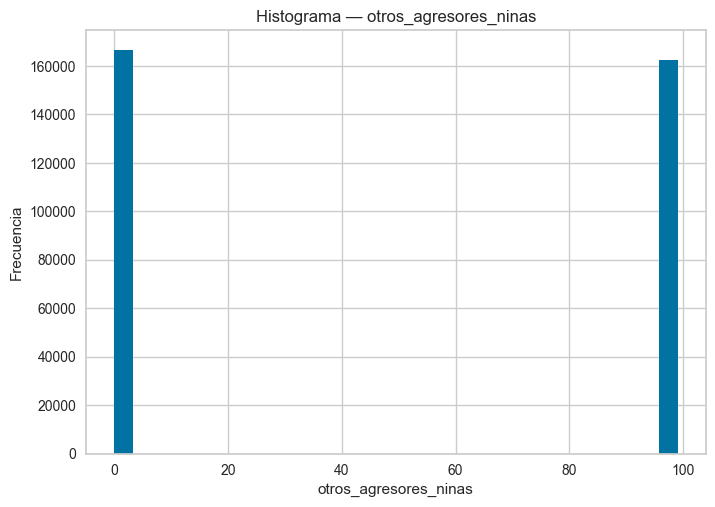

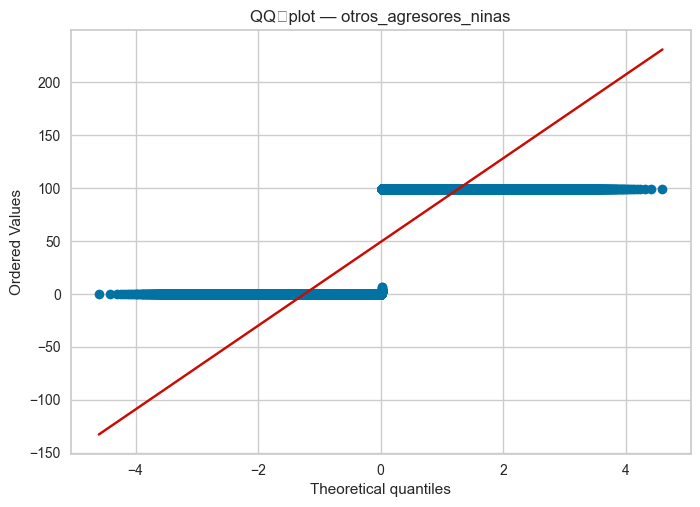

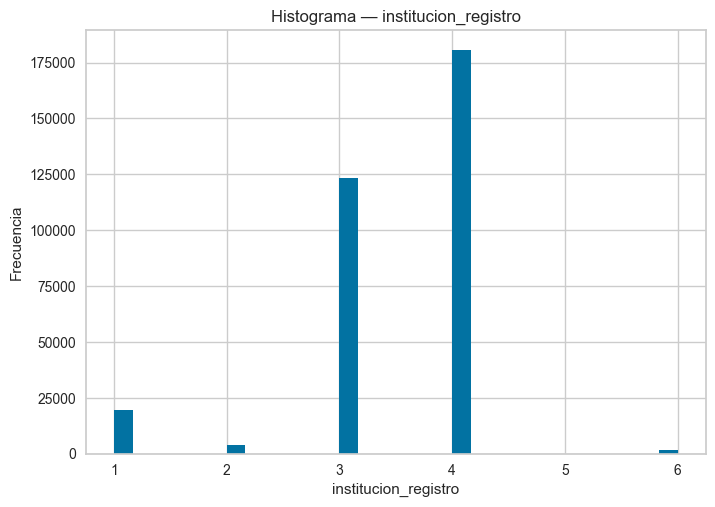

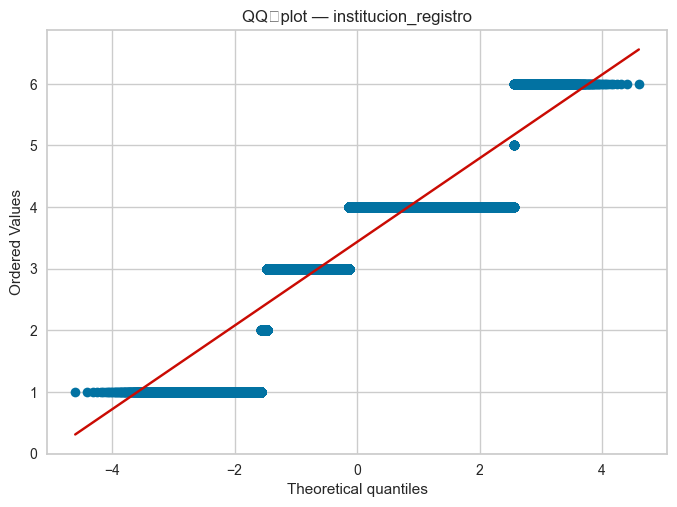

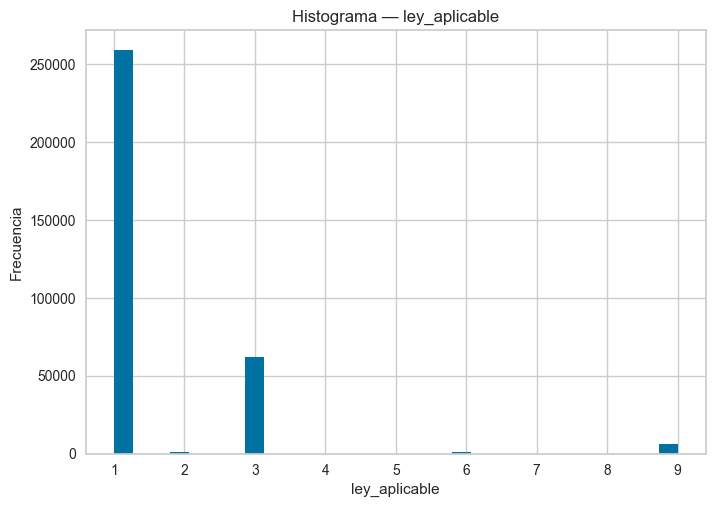

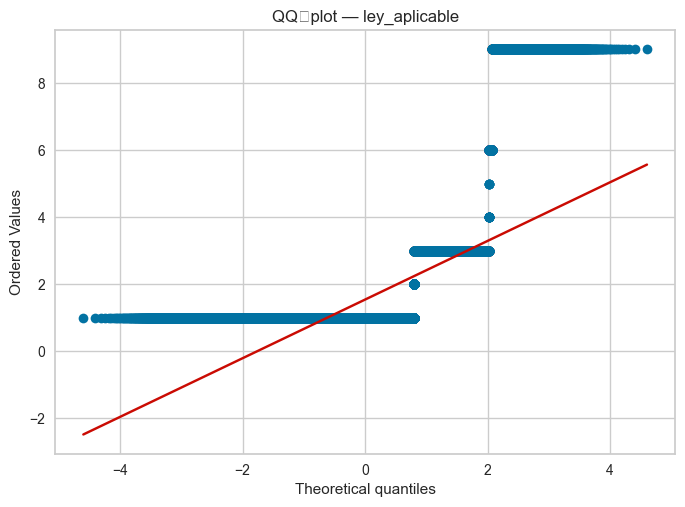

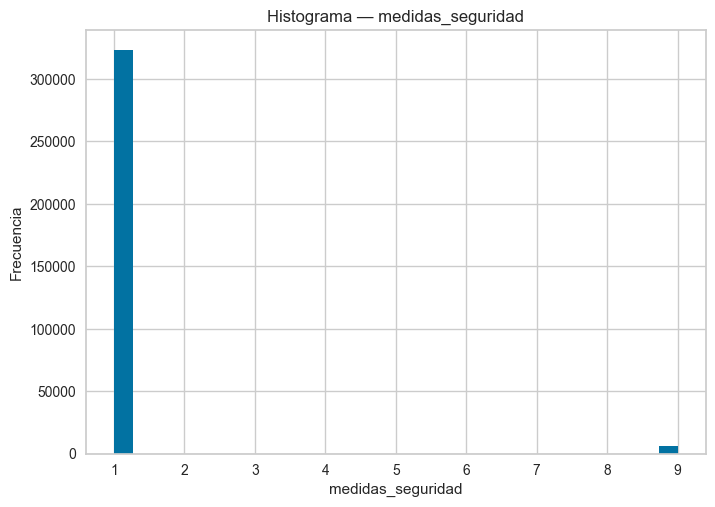

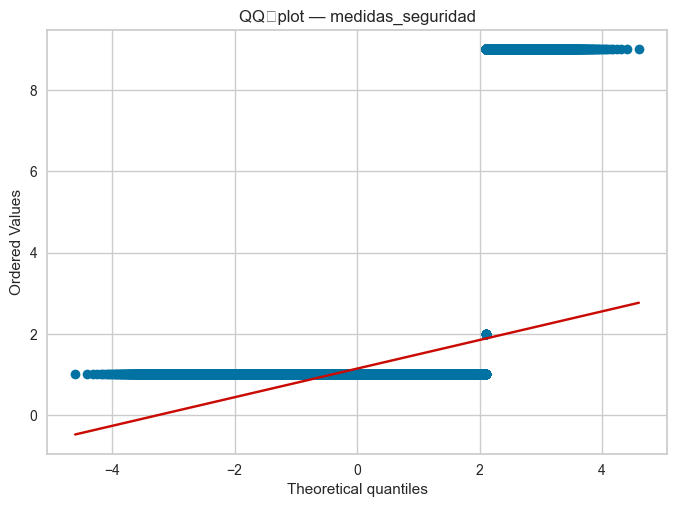

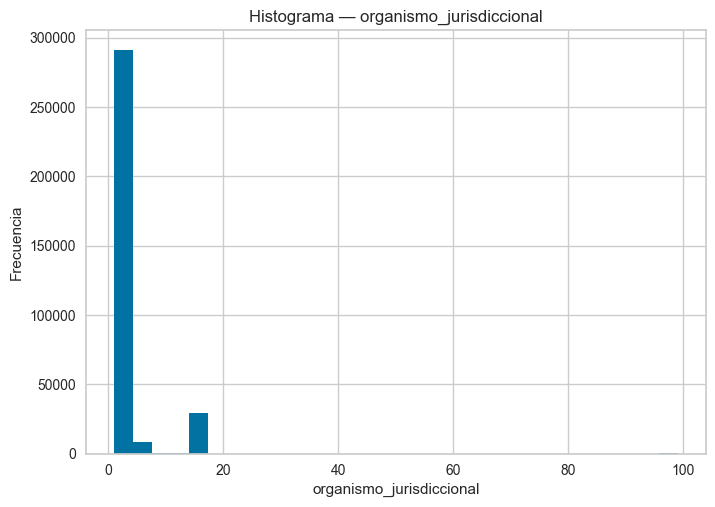

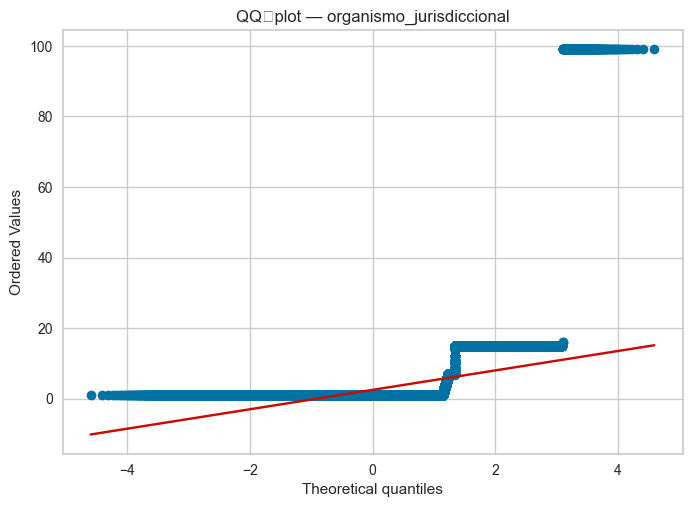

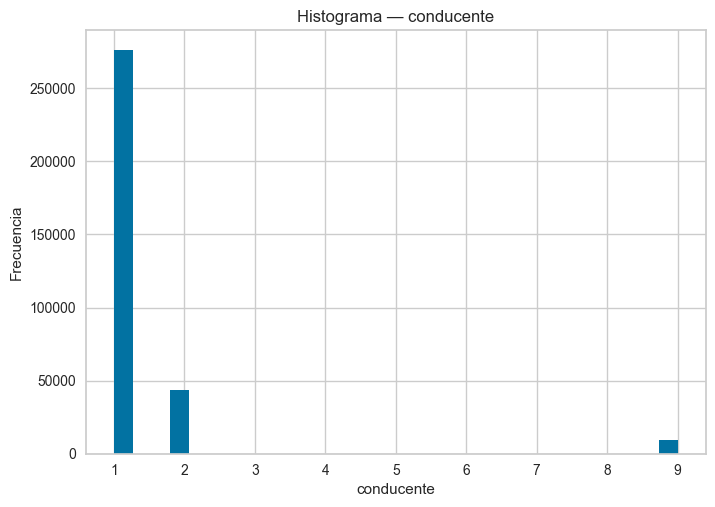

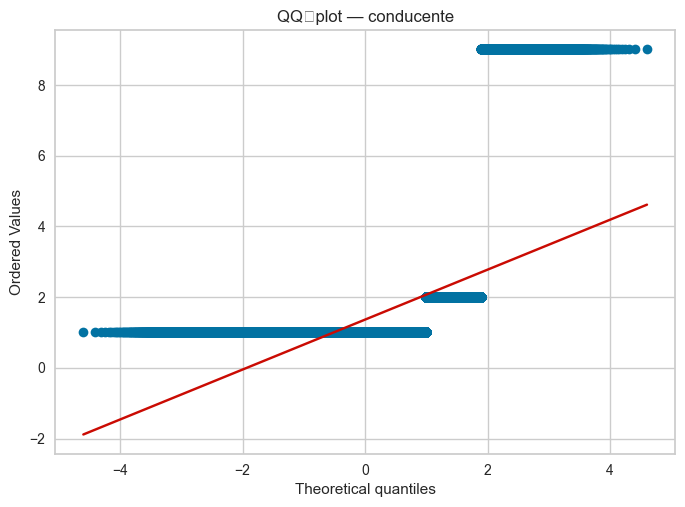

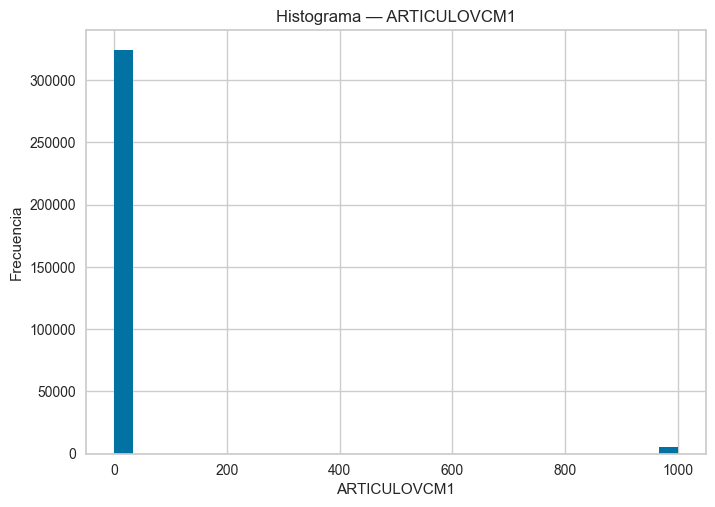

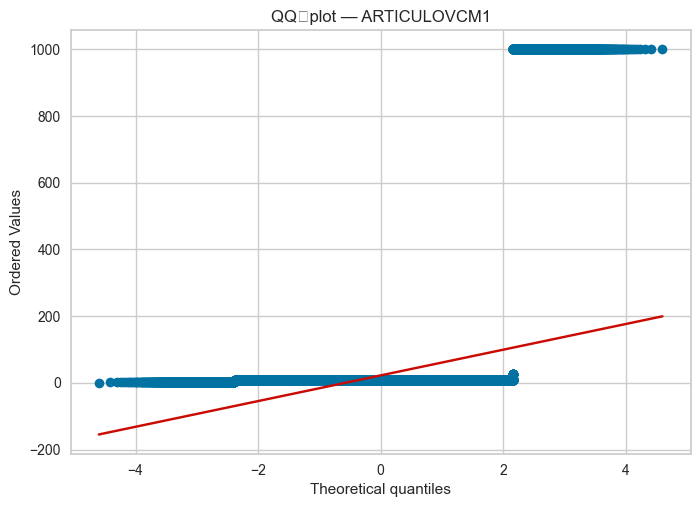

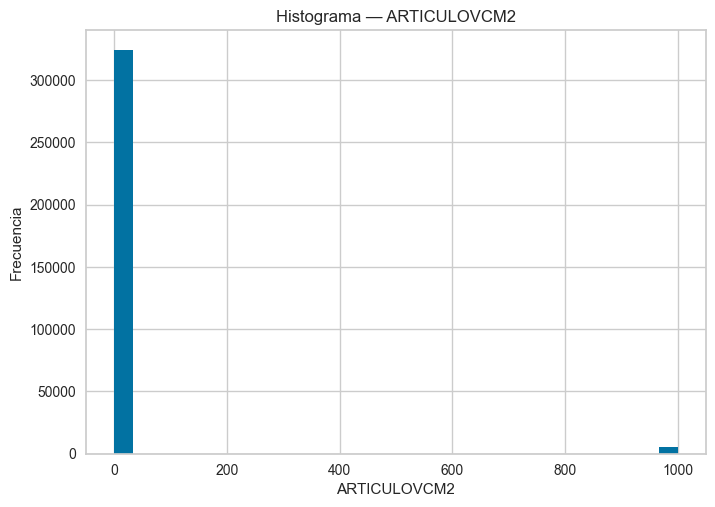

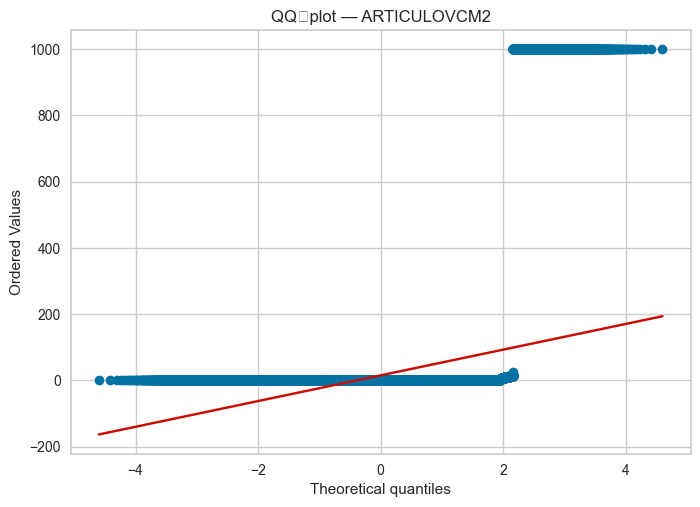

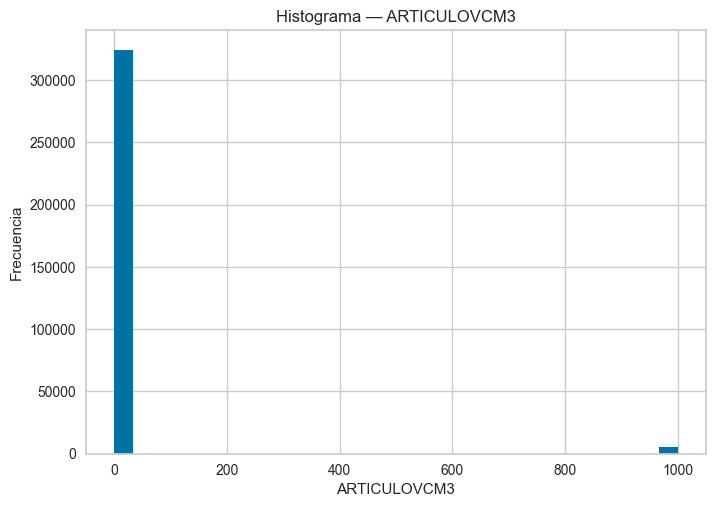

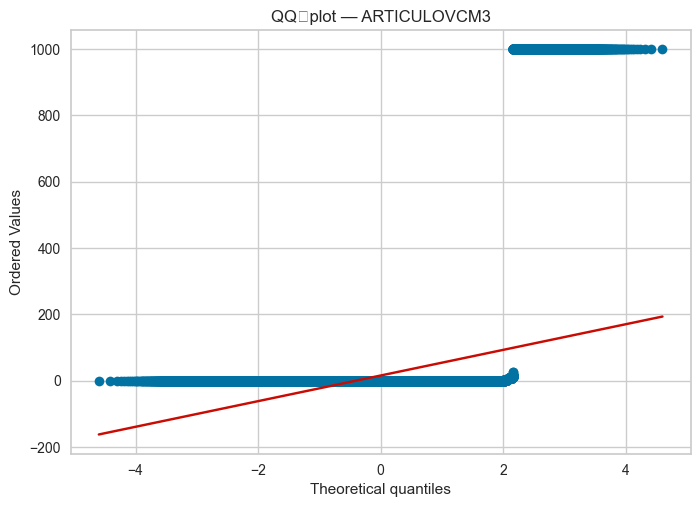

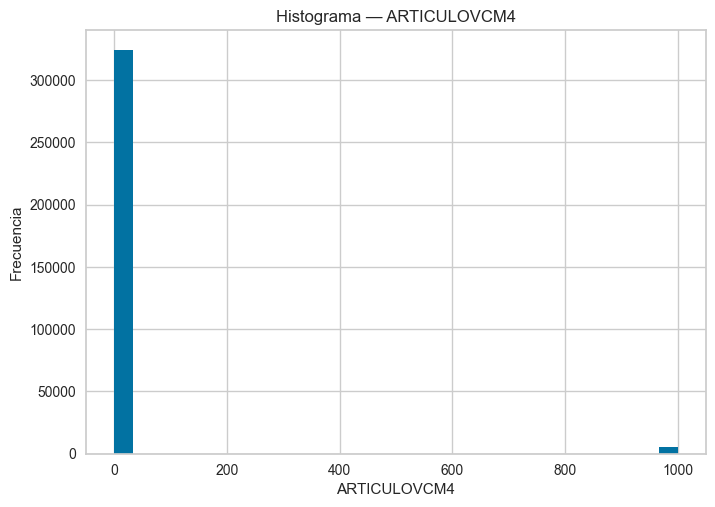

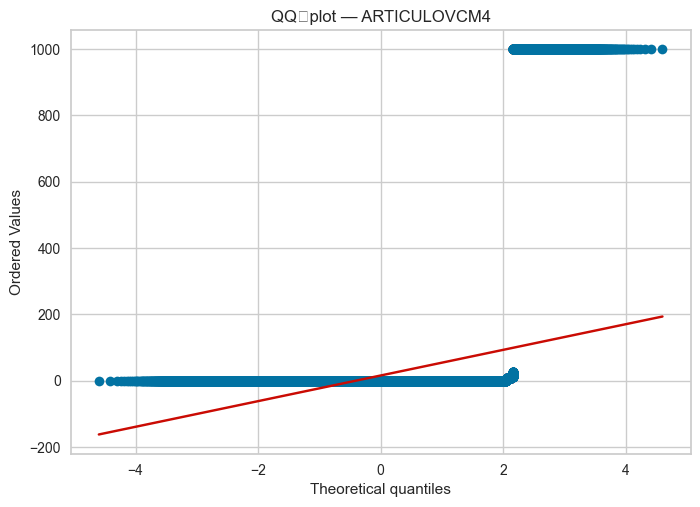

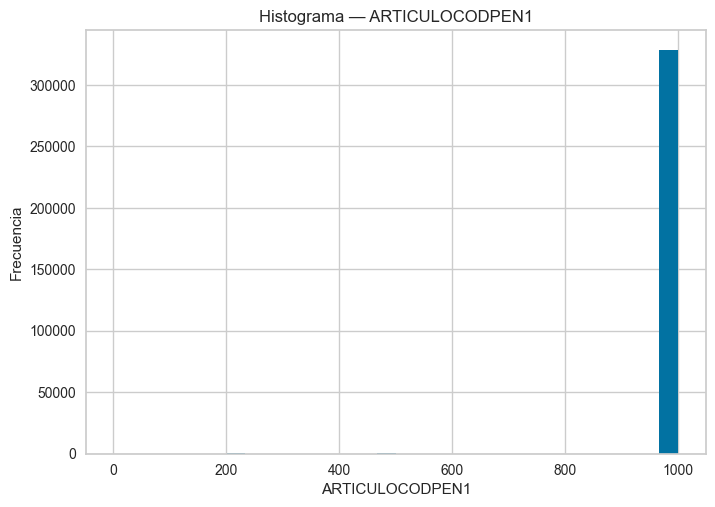

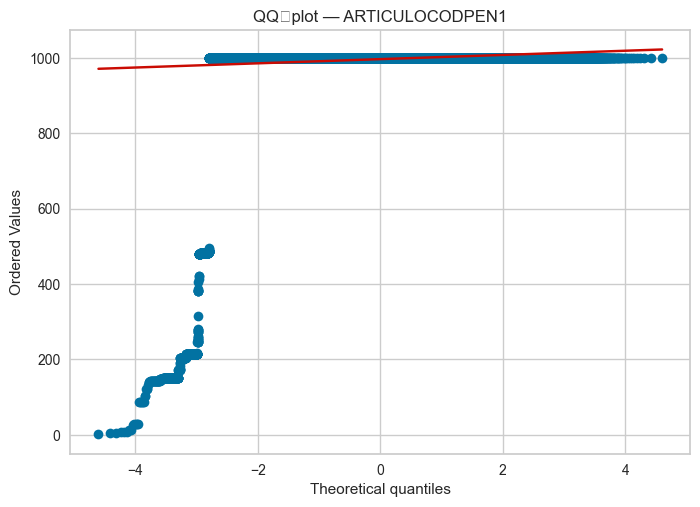

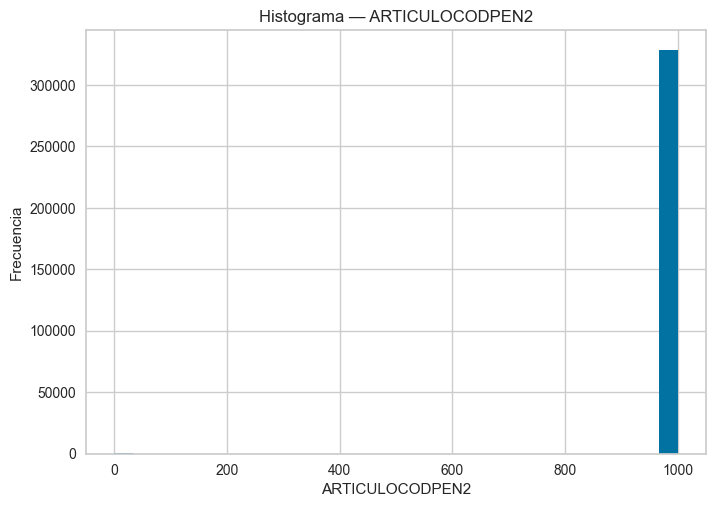

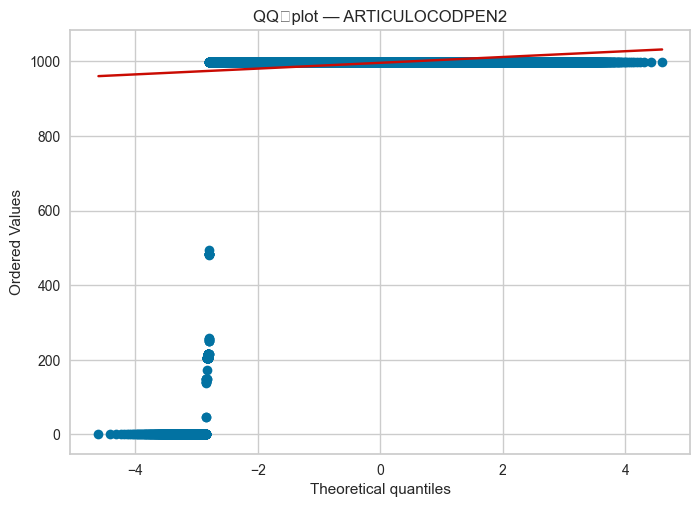

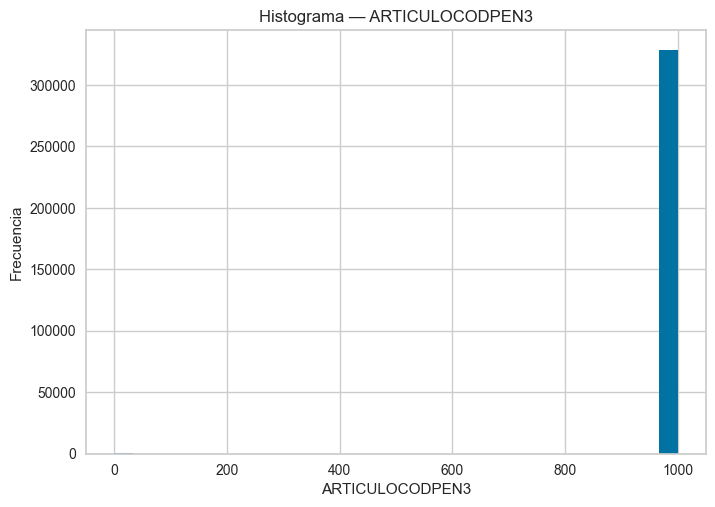

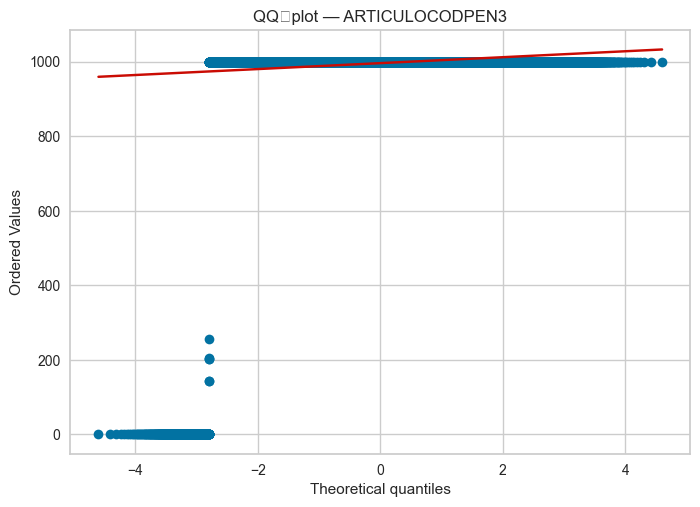

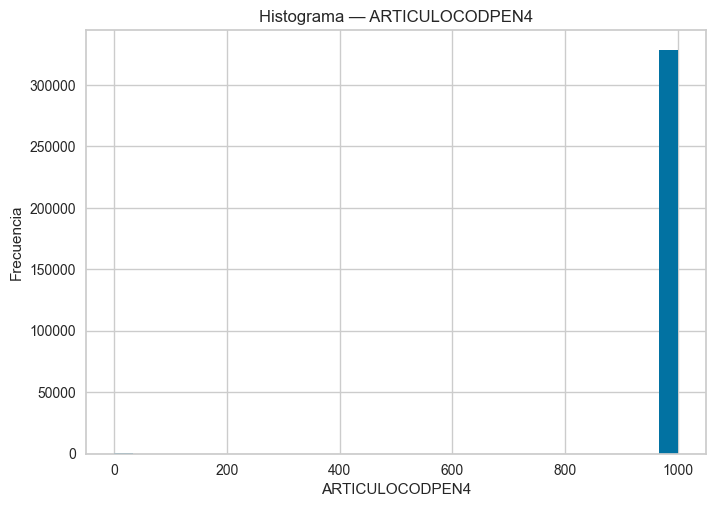

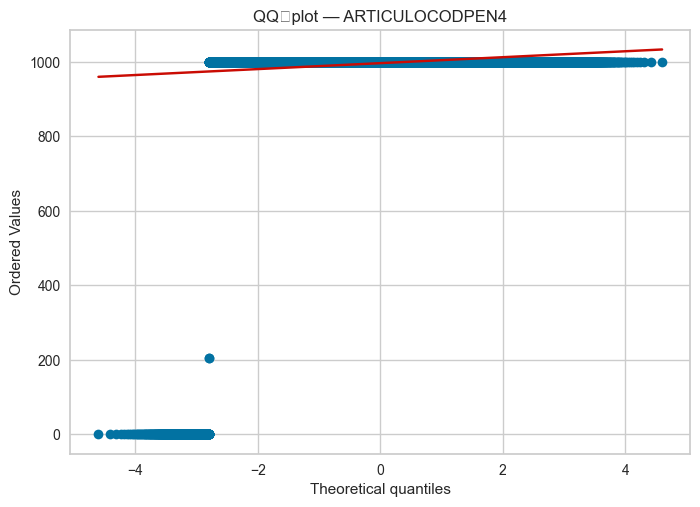

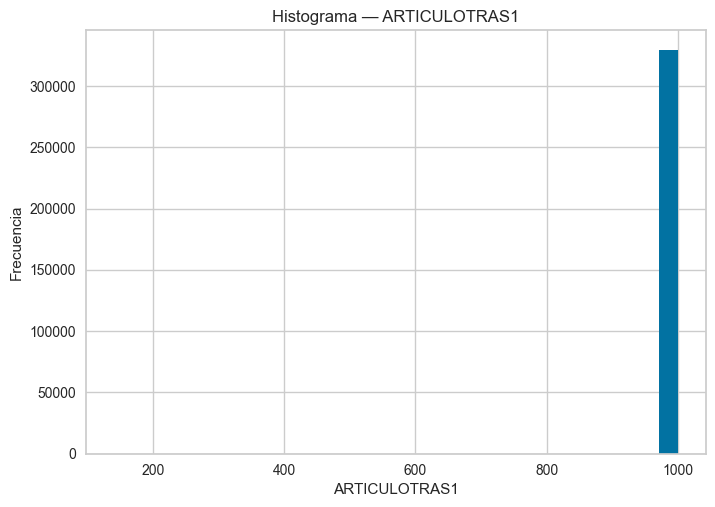

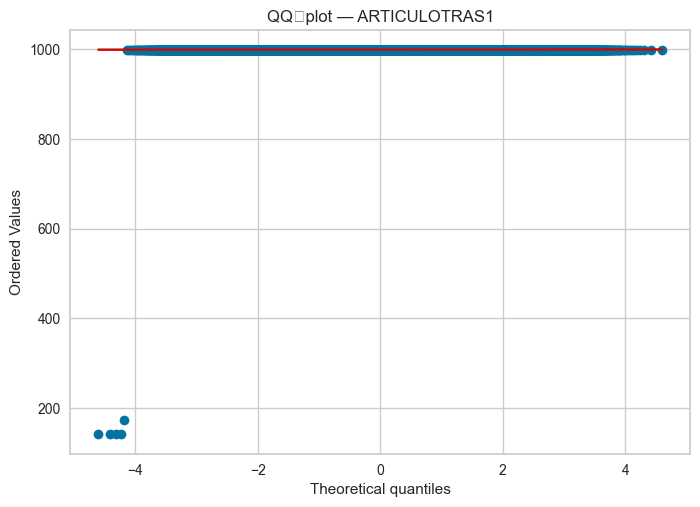

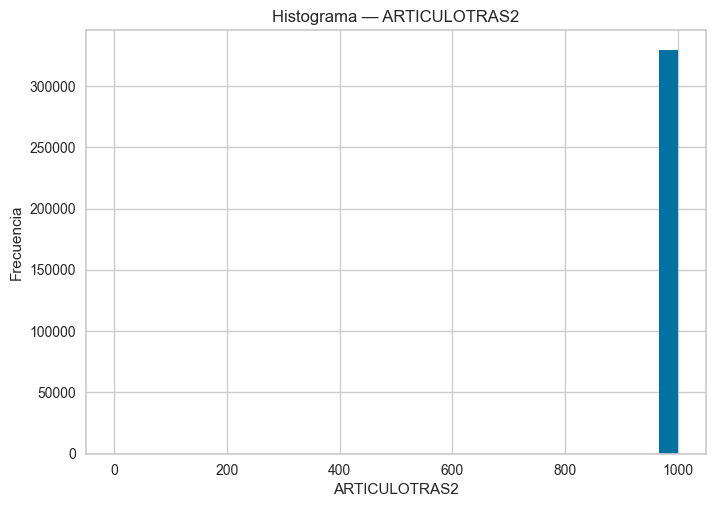

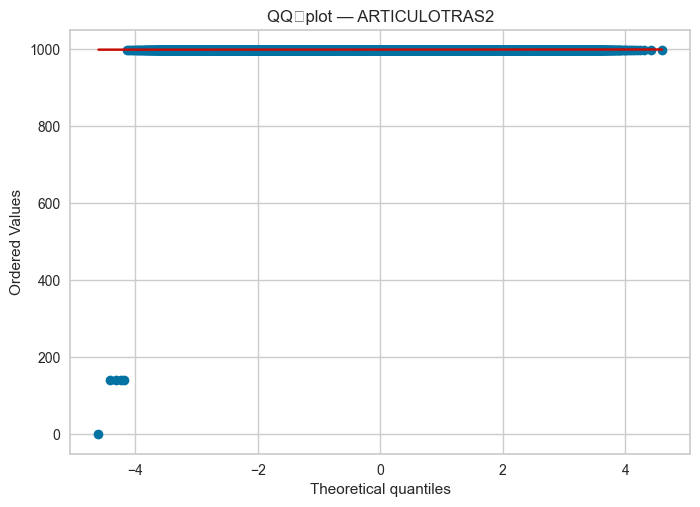

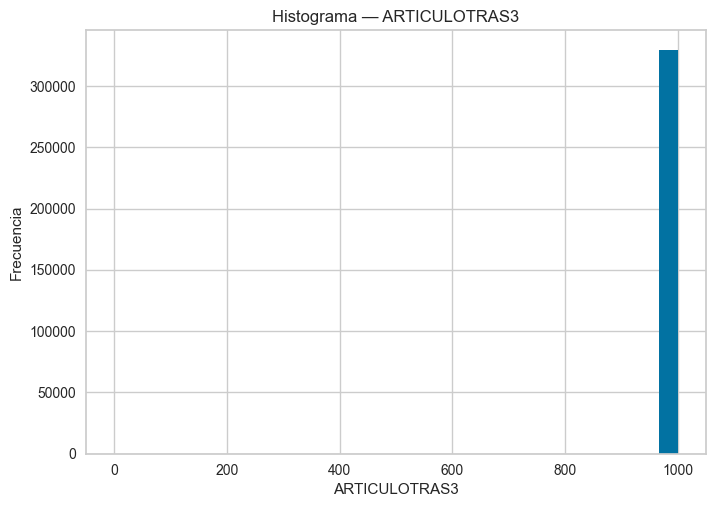

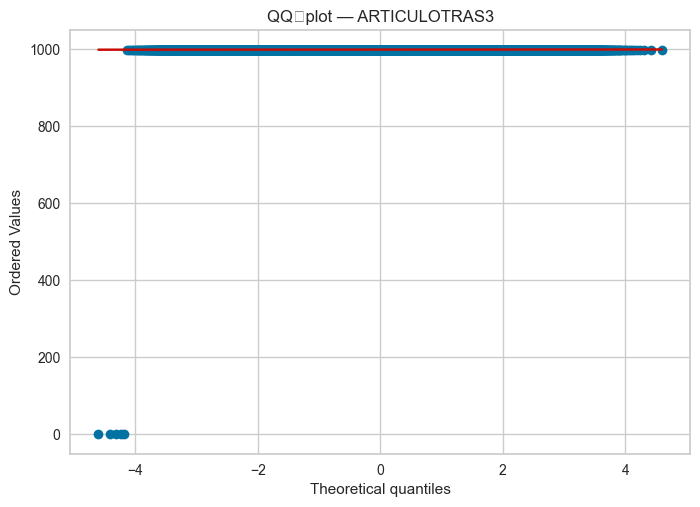

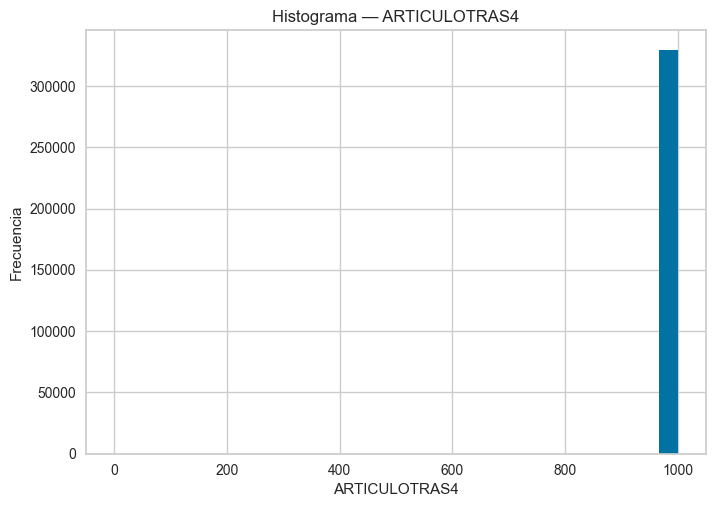

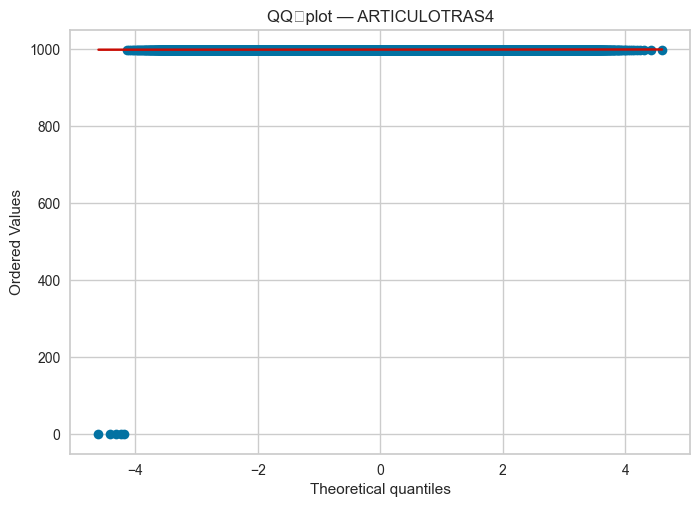

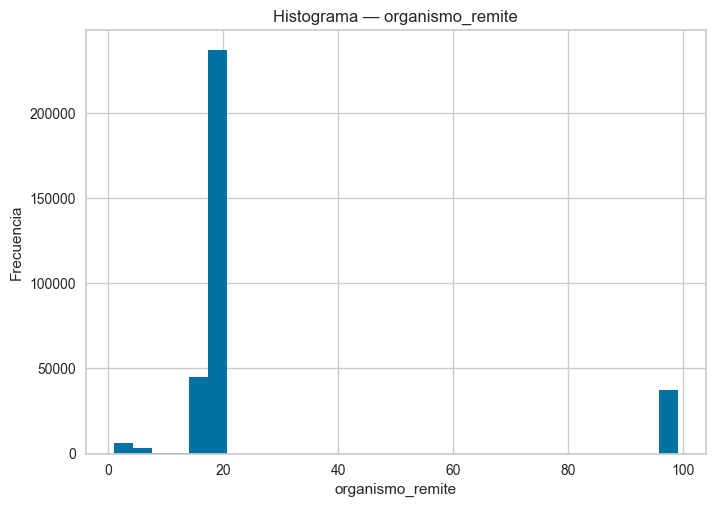

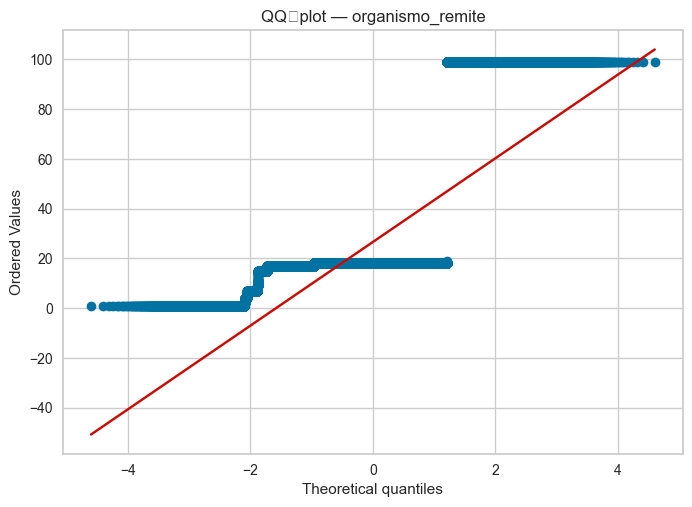

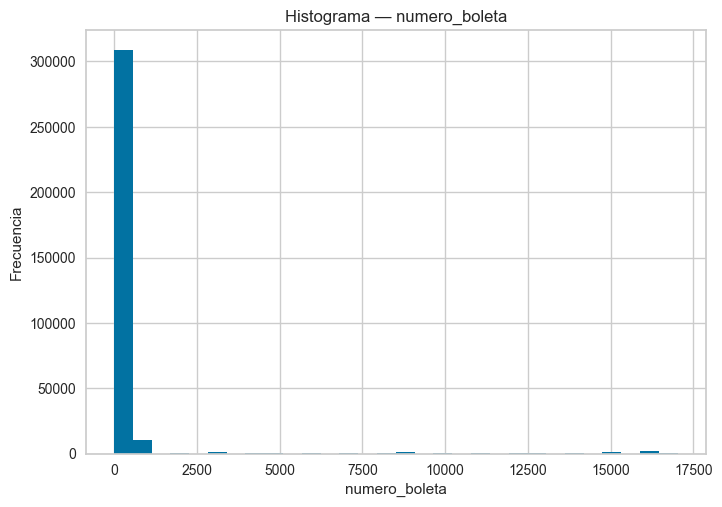

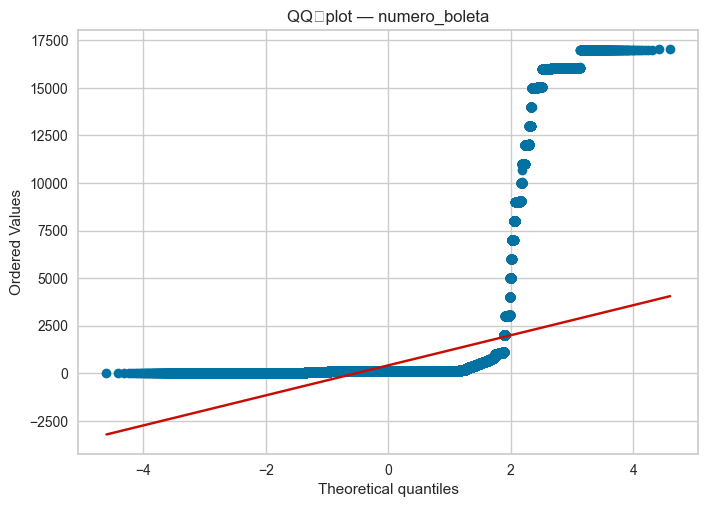

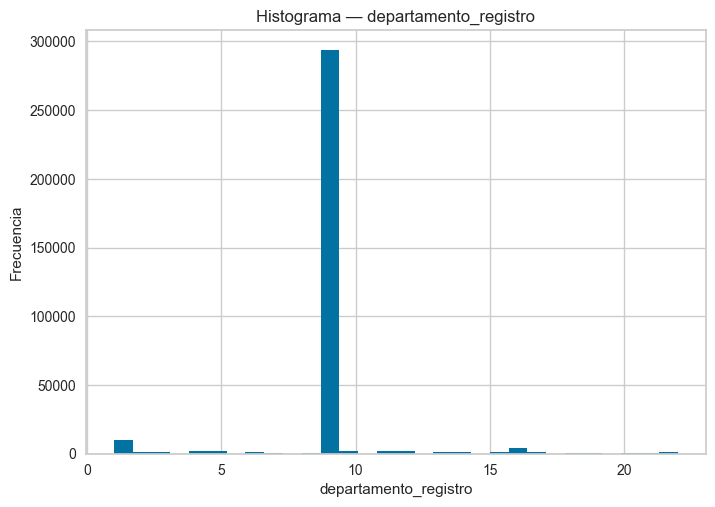

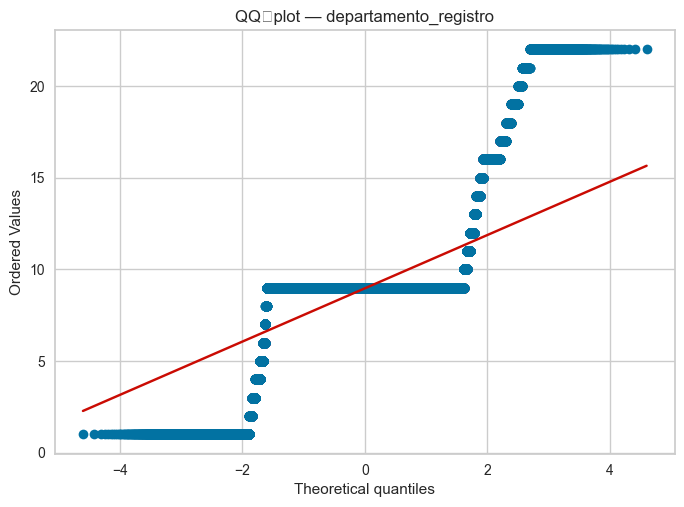

In [ ]:
num_cols = df.select_dtypes(include='number').columns.tolist()
print("\n📊 Estadísticas descriptivas — Variables numéricas")
display(df[num_cols].describe().T)

import scipy.stats as stats

print("\n🔬 Prueba de normalidad (Shapiro–Wilk)")
normal_results = []
for col in num_cols:
    data = df[col].dropna()
    if len(data) >= 3:
        stat, p = stats.shapiro(data)
        normal_results.append((col, stat, p))
        print(f"{col}: W={stat:.4f}, p={p:.4f} {'(No normal)' if p<0.05 else '(Normal)'}")
        
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

    plt.figure()
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ‑plot — {col}")
    plt.show()


- Variables categóricas

In [ ]:
cat_cols = df.select_dtypes(include='category').columns.tolist()
print("\n📊 Frecuencias — Variables categóricas")
for col in cat_cols:
    print(f"\n== {col} ==")
    display(df[col].value_counts(dropna=False).to_frame("frecuencia"))


📊 Frecuencias — Variables categóricas

== dia_ocurrencia ==


frecuencia
dia_ocurrencia            
1                    13745
2                    12169
5                    11658
3                    11568
15                   11545
10                   11475
4                    11291
20                   11182
8                    10893
18                   10881
12                   10853
6                    10832
17                   10827
7                    10786
9                    10712
16                   10542
25                   10536
11                   10482
14                   10355
13                   10296
19                   10244
24                   10100
22                   10072
21                   10044
27                   10008
26                    9963
28                    9956
23                    9951
29                    8420
30                    8414
31                    5420
99                    3739


== mes_ocurrencia ==


frecuencia
mes_ocurrencia            
5                    28816
7                    28770
8                    28355
3                    28201
6                    27399
4                    27306
1                    26868
2                    26619
9                    26467
10                   26191
11                   25420
12                   24807
99                    3740


== anio_ocurrencia ==


frecuencia
anio_ocurrencia            
2022                  36565
2021                  36318
2023                  35832
2014                  33653
2019                  31538
2015                  31343
2016                  30845
2017                  29957
2018                  29895
2020                  28270
9999                   3740
2013                    667
2012                     99
2011                     62
2010                     57
2009                     28
2008                     19
2001                     15
2006                     15
2004                     12
2005                     10
2002                      6
2007                      6
2003                      5
2000                      2


== tipo_agresion ==


frecuencia
tipo_agresion            
2122.0             134890
1122.0             113027
1222.0              36997
1121.0              17034
2121.0              15791
2221.0               3790
1112.0               2220
2112.0               1403
2212.0               1155
1111.0               1153
1221.0                662
1212.0                541
2111.0                172
1211.0                 67
2211.0                 57


== dia_registro ==


frecuencia
dia_registro            
3                  12188
4                  11883
5                  11715
2                  11704
18                 11436
6                  11420
8                  11345
7                  11191
11                 11006
13                 10990
17                 10979
12                 10921
9                  10920
27                 10905
10                 10881
16                 10828
19                 10810
21                 10777
20                 10755
28                 10737
14                 10672
22                 10550
1                  10402
23                 10329
24                 10279
25                 10250
26                 10163
15                 10075
29                  8977
30                  8762
31                  5109


== mes_registro ==


frecuencia
mes_registro            
7                  29257
8                  29088
5                  29041
3                  28644
6                  27724
4                  27552
9                  26939
1                  26898
2                  26648
10                 26549
11                 25992
12                 24627


== anio_registro ==


frecuencia
anio_registro            
2023                37348
2022                37194
2021                36435
2014                34330
2015                31929
2019                31898
2016                31190
2017                30384
2018                29992
2020                28259


== sexo_victima ==


frecuencia
sexo_victima            
2.0               287813
1.0                41146


== estado_civil_victima ==


frecuencia
estado_civil_victima            
 2.0                      131244
 3.0                       81538
 9.0                       70013
 1.0                       32180
 5.0                        9735
 4.0                        2575
NaN                         1674


== pueblo_victima ==


frecuencia
pueblo_victima            
1.0                 185231
2.0                  97351
6.0                  39154
9.0                   4637
5.0                   1632
4.0                    508
3.0                    446


== nacionalidad_victima ==


frecuencia
nacionalidad_victima            
1.0                       325370
9.0                         1962
2.0                         1627


== trabaja_victima ==


frecuencia
trabaja_victima            
 2.0                 214753
 1.0                 111856
 9.0                   1665
NaN                     685


== relacion_victima_agresor ==


frecuencia
relacion_victima_agresor            
2.0                            96531
1.0                            93698
3.0                            54002
10.0                           35027
9.0                            18482
6.0                            15857
4.0                             8008
8.0                             5472
5.0                             1339
7.0                              543


== tipo_medida ==


frecuencia
tipo_medida            
NaN              149851
IJ               110290
AIJ               20239
Z                 12343
I                  6985
...                 ...
IJKLM                 1
IJKMN                 1
IJKÑ                  1
IJLMN                 1
ABCFGIJH              1

[890 rows x 1 columns]


== cod_dep_ocurrencia ==


frecuencia
cod_dep_ocurrencia            
NaN                     328959


== cod_mun_ocurrencia ==


frecuencia
cod_mun_ocurrencia            
NaN                     328959


== cod_dep_registro ==


frecuencia
cod_dep_registro            
NaN                   328959


== cod_mun_registro ==


frecuencia
cod_mun_registro            
NaN                   328959

# **Análisis exploratorio, tipo_medida**

📋 Frecuencias por medida (incluye NoMeasure):
             count  percent
I          162885    49.52
J          154812    47.06
A           29603     9.00
C           13296     4.04
B            6097     1.85
N            5094     1.55
K            3895     1.18
F            2937     0.89
G            2349     0.71
D             717     0.22
E             582     0.18
L             579     0.18
M             540     0.16
H             477     0.15
O             369     0.11
Ñ              95     0.03
NoMeasure  162194    49.31

📊 Resumen anual:
                total  invalid  valid  pct_invalid
anio_registro                                    
2014.0         34330    17883  16447        52.09
2015.0         31929    16422  15507        51.43
2016.0         31190    16097  15093        51.61
2017.0         30384    14067  16317        46.30
2018.0         29992    13903  16089        46.36
2019.0         31898    16474  15424        51.65
2020.0         28259    14558  13701        51.5

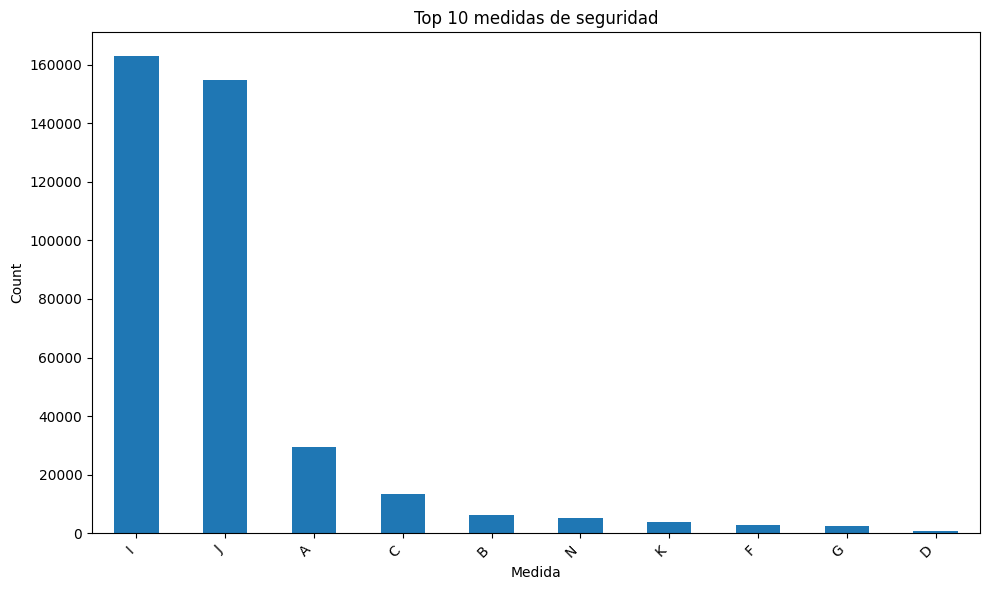

<Figure size 1000x600 with 0 Axes>

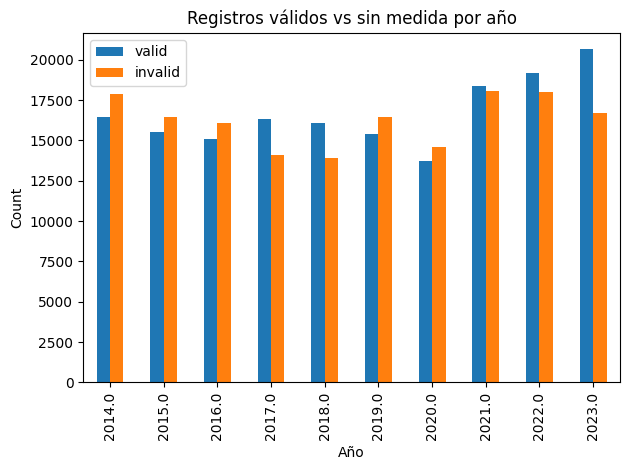

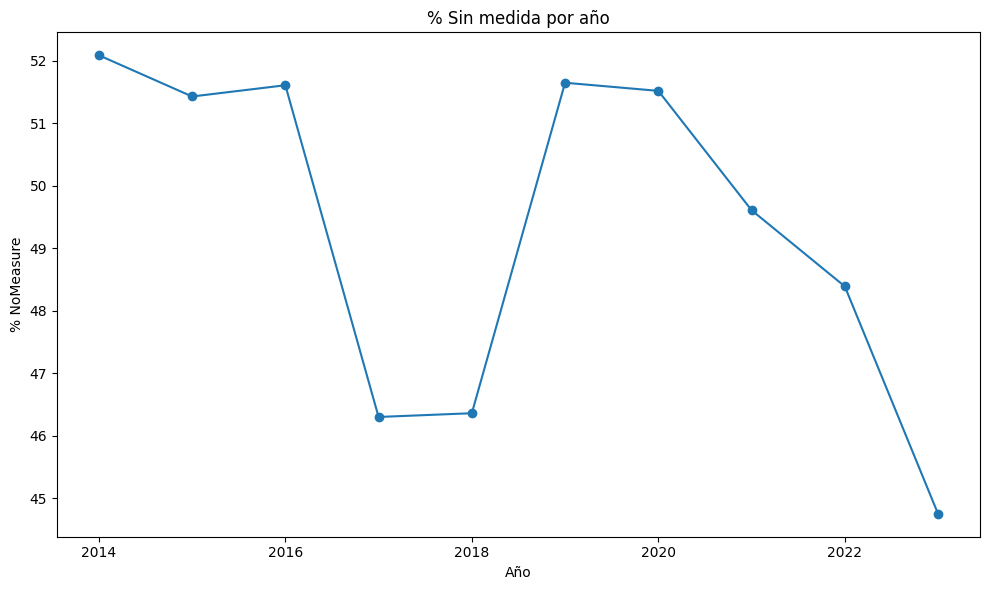

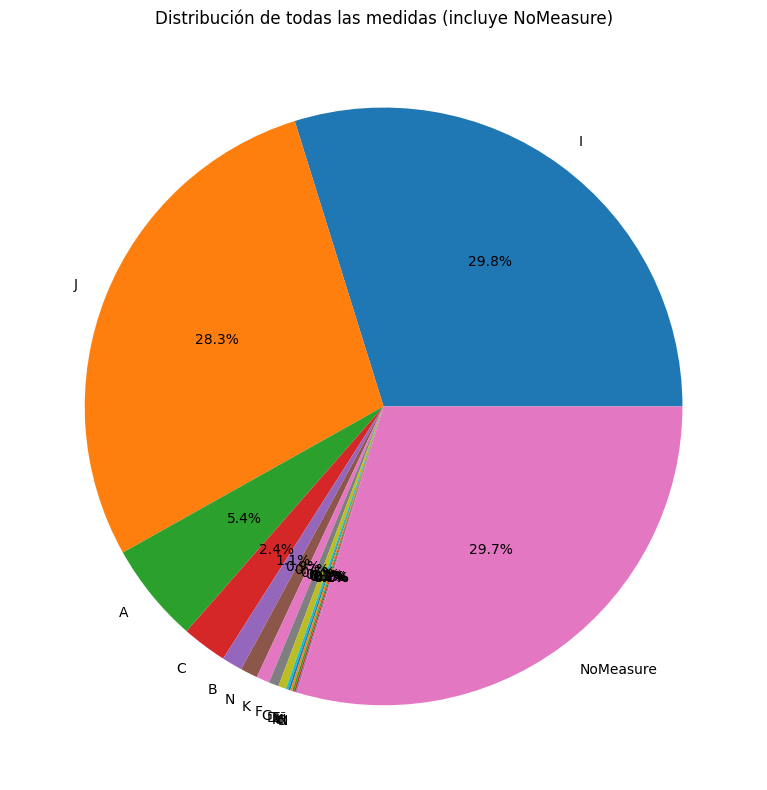

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Leer CSV transformado
df = pd.read_csv("todoscsvs_transformado.csv", usecols=lambda c: c in list("ABCDEFGHIJKLMNÑO") + ["anio_registro"])

# 2️⃣ Calcular frecuencia de cada medida
measures = list("ABCDEFGHIJKLMNÑO")
freq = df[measures].sum().sort_values(ascending=False)

# 3️⃣ Calcular NoMeasure (ausencia de cualquier 1)
no_measure_count = (df[measures].sum(axis=1) == 0).sum()

# 4️⃣ Construir DataFrame de resumen incluyendo NoMeasure
count_series = pd.concat([freq, pd.Series({'NoMeasure': no_measure_count})])
summary = pd.DataFrame({
    'count': count_series
})
summary['percent'] = (summary['count'] / len(df) * 100).round(2)

print("📋 Frecuencias por medida (incluye NoMeasure):\n", summary)

# 5️⃣ Agrupar por año para valid vs invalid
df['NoMeasure_flag'] = df[measures].sum(axis=1) == 0
annual = df.groupby('anio_registro').agg(
    total=('NoMeasure_flag','size'),
    invalid=('NoMeasure_flag','sum')
).sort_index()
annual['valid'] = annual['total'] - annual['invalid']
annual['pct_invalid'] = (annual['invalid'] / annual['total'] * 100).round(2)

print("\n📊 Resumen anual:\n", annual)

# 6️⃣ VISUALIZACIONES

# A) Top‑10 medidas
plt.figure(figsize=(10,6))
summary.head(10)['count'].plot(kind='bar')
plt.title("Top 10 medidas de seguridad")
plt.ylabel("Count")
plt.xlabel("Medida")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# B) Valid vs Invalid por año
plt.figure(figsize=(10,6))
annual[['valid','invalid']].plot(kind='bar')
plt.title("Registros válidos vs sin medida por año")
plt.ylabel("Count")
plt.xlabel("Año")
plt.tight_layout()
plt.show()

# C) % sin medida a lo largo del tiempo
plt.figure(figsize=(10,6))
annual['pct_invalid'].plot(marker='o')
plt.title("% Sin medida por año")
plt.ylabel("% NoMeasure")
plt.xlabel("Año")
plt.tight_layout()
plt.show()

# D) Pie chart: Todas las medidas
plt.figure(figsize=(8,8))
summary['count'].plot(kind='pie', autopct='%1.1f%%')
plt.title("Distribución de todas las medidas (incluye NoMeasure)")
plt.ylabel("")
plt.tight_layout()
plt.show()



# 📊 Análisis Exploratorio de la Variable Objetivo (`tipo_medida`)

## 📋 Frecuencias por medida (incluye NoMeasure)

| Medida      | Count  | Percent (%) |
|-------------|--------|-------------|
| I           | 162,885 | 49.52       |
| J           | 154,812 | 47.06       |
| NoMeasure   | 162,194 | 49.31       |
| A           | 29,603  | 9.00        |
| C           | 13,296  | 4.04        |
| B           | 6,097   | 1.85        |
| N           | 5,094   | 1.55        |
| K           | 3,895   | 1.18        |
| F           | 2,937   | 0.89        |
| G           | 2,349   | 0.71        |
| D           | 717     | 0.22        |
| E           | 582     | 0.18        |
| L           | 579     | 0.18        |
| M           | 540     | 0.16        |
| H           | 477     | 0.15        |
| O           | 369     | 0.11        |
| Ñ           | 95      | 0.03        |

> 💡 **Insight principal:** Las medidas **I** y **J** aparecen en casi la mitad de los casos cada una; casi la misma proporción de casos (**49.3%**) no tienen medida alguna (`NoMeasure`). Todas las demás medidas ocurren en <10% de los registros.

---

## 📊 Resumen anual de registros válidos vs sin medida

| Año    | Total registros | Sin medida (`invalid`) | Con medida (`valid`) | % Sin medida |
|--------|-----------------|------------------------|----------------------|--------------|
| 2014   | 34,330          | 17,883 (52.09%)        | 16,447               | 52.09%       |
| 2015   | 31,929          | 16,422 (51.43%)        | 15,507               | 51.43%       |
| 2016   | 30,154          | 15,145 (50.21%)        | 15,009               | 50.21%       |
| 2017   | 29,996          | 13,868 (46.28%)        | 16,128               | 46.28%       |
| 2018   | 28,259          | 13,019 (46.07%)        | 15,240               | 46.07%       |
| 2019   | 29,502          | 14,632 (49.60%)        | 14,870               | 49.60%       |
| 2020   | 28,259          | 14,558 (51.52%)        | 13,701               | 51.52%       |
| 2021   | 36,435          | 18,077 (49.61%)        | 18,358               | 49.61%       |
| 2022   | 37,194          | 17,998 (48.39%)        | 19,196               | 48.39%       |
| 2023   | 37,348          | 16,715 (44.75%)        | 20,633               | 44.75%       |

> 📈 **Tendencia:** La proporción de casos sin medida ha ido decreciendo desde un pico ~52% en 2014–2015 hasta ~44.8% en 2023, sugiriendo un aumento gradual en la aplicación de alguna medida de seguridad.

---

## 🎯 Conclusiones para modelado

1. **Objetivo multi‑etiqueta desequilibrado**  
   - `I` y `J` dominan (~50% cada una).  
   - Resto de etiquetas ocurren muy raramente (<2%).  
   - `NoMeasure` es casi tan frecuente como `I`.

2. **Recomendaciones de preprocesamiento**  
   - Mantener columnas binarias para cada etiqueta (incluyendo `NoMeasure`).  
   - Considerar técnicas de balanceo (oversampling SMOTE, ajuste de pesos) especialmente para etiquetas raras.

3. **Estrategia de evaluación**  
   - Métrica principal: Hamming loss + macro F1-score.  
   - Métrica secundaria: Exact match ratio (predicción de combinación completa).  
   - Analizar performance por etiqueta individual (especialmente `A`, `C`, etc).

4. **Consideraciones temporales**  
   - La proporción de “sin medida” varía año a año; incluir `anio_registro` como feature puede ayudar a capturar tendencia temporal.



In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
import multiprocessing


CHUNKSIZE = 100_000  
INPUT_FILE = "todoscsvs_transformado.csv"
df_chunks = pd.read_csv(INPUT_FILE, chunksize=CHUNKSIZE)
df_list = [chunk for chunk in df_chunks]
df = pd.concat(df_list, axis=0)


measures = list("ABCDEFGHIJKLMNÑO")
if "NoMeasure" not in df.columns:
    df["NoMeasure"] = (df[measures].sum(axis=1) == 0).astype(int)


targets = measures + ["NoMeasure"]


X = df.drop(columns=targets + ["anio_registro"])

label_encoders = {}
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  


def compute_mi(target_name):
    y = df[target_name]
    mi_scores = mutual_info_classif(X.fillna(-1), y, discrete_features='auto', random_state=42)
    return target_name, mi_scores


num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(compute_mi)(target) for target in targets)

mi_dict = {target: mi_scores for target, mi_scores in results}
mi_df = pd.DataFrame(mi_dict, index=X.columns)


print("\n📋 Mutual Information entre features y cada etiqueta:\n", mi_df)


mi_df.to_csv("feature_target_mutual_info_optimizado.csv")



📋 Mutual Information entre features y cada etiqueta:
                                  A         B         C         D         E  \
dia_ocurrencia            0.002652  0.002230  0.002209  0.002277  0.002368   
mes_ocurrencia            0.003203  0.003366  0.003577  0.003657  0.003689   
anio_ocurrencia           0.007697  0.009053  0.008425  0.008548  0.008319   
dep_municipio_ocurrencia  0.033904  0.022533  0.069436  0.004213  0.002315   
tipo_agresion             0.027099  0.030525  0.029815  0.031368  0.031641   
...                            ...       ...       ...       ...       ...   
ARTICULOTRAS3             0.000910  0.000975  0.000989  0.000806  0.000811   
ARTICULOTRAS4             0.001193  0.000799  0.000988  0.000661  0.000744   
organismo_remite          0.026437  0.010982  0.014767  0.006196  0.005663   
numero_boleta             0.005863  0.003454  0.005461  0.000880  0.000329   
departamento_registro     0.019994  0.022849  0.022214  0.021884  0.021163   

        

# Análisis de Información Mutua (Mutual Information)

## Introducción
El cálculo de la Información Mutua (MI) se utiliza para medir la fuerza de la relación entre cada variable predictora y cada variable objetivo. En este análisis, hemos calculado la MI entre las características del dataset y cada uno de los siguientes objetivos: A, B, C, D, E, F, G, H, I, J, K, L, M, N, Ñ, O, NoMeasure.

### Criterio de Evaluación
- 🔥 **Buena variable predictora:** MI > 0.05 (Relación moderada a fuerte).
- ⚡️ **Aceptable:** MI entre 0.01 y 0.05 (Relación débil a moderada).
- ❌ **Baja relevancia:** MI < 0.01 (Relación muy débil o inexistente).

---

## 📋 Variables Más Relevantes (TOP 5 por cada medida)
| Medida   | Mejores Variables Predictoras (MI) |
|----------|-------------------------------------|
| A        | institucion_registro (0.0868), ley_aplicable (0.0823), medidas_seguridad (0.0837), quien_reporta (0.0665), otras_victimas_total (0.0286) |
| B        | institucion_registro (0.0469), quien_reporta (0.0773), otras_victimas_total (0.0323), tipo_agresion (0.0305), pueblo_victima (0.0258) |
| C        | dep_municipio_ocurrencia (0.0694), dep_municipio_registro (0.0751), institucion_registro (0.0584), institucion_denuncia_previa (0.0209), ley_aplicable (0.0469) |
| D        | otras_victimas_total (0.0334), quien_reporta (0.0796), tipo_agresion (0.0314), dep_municipio_ocurrencia (0.0042), anio_ocurrencia (0.0085) |
| E        | otras_victimas_total (0.0334), tipo_agresion (0.0316), quien_reporta (0.0795), institucion_registro (0.0387), medidas_seguridad (0.0274) |
| F        | institucion_registro (0.0421), medidas_seguridad (0.0315), tipo_agresion (0.0316), otras_victimas_total (0.0334), quien_reporta (0.0786) |
| G        | institucion_registro (0.0411), medidas_seguridad (0.0315), tipo_agresion (0.0312), otras_victimas_total (0.0333), quien_reporta (0.0787) |
| H        | institucion_registro (0.0385), medidas_seguridad (0.0315), tipo_agresion (0.0315), otras_victimas_total (0.0335), quien_reporta (0.0798) |
| I        | institucion_registro (0.5496), ley_aplicable (0.5936), medidas_seguridad (0.5983), organismo_jurisdiccional (0.2863), organismo_remite (0.2878) |
| J        | institucion_registro (0.4965), ley_aplicable (0.5342), medidas_seguridad (0.5363), organismo_jurisdiccional (0.2508), organismo_remite (0.2496) |
| K        | institucion_registro (0.0438), medidas_seguridad (0.0334), tipo_agresion (0.0316), quien_reporta (0.0782), otras_victimas_total (0.0328) |
| L        | institucion_registro (0.0387), medidas_seguridad (0.0271), tipo_agresion (0.0316), otras_victimas_total (0.0334), quien_reporta (0.0795) |
| M        | institucion_registro (0.0387), medidas_seguridad (0.0271), tipo_agresion (0.0316), otras_victimas_total (0.0334), quien_reporta (0.0795) |
| N        | institucion_registro (0.0454), medidas_seguridad (0.0351), tipo_agresion (0.0316), otras_victimas_total (0.0334), quien_reporta (0.0796) |
| Ñ        | institucion_registro (0.0379), medidas_seguridad (0.0261), tipo_agresion (0.0315), otras_victimas_total (0.0335), quien_reporta (0.0798) |
| O        | institucion_registro (0.5784), ley_aplicable (0.6305), medidas_seguridad (0.6341), organismo_jurisdiccional (0.3039), organismo_remite (0.3062) |
| NoMeasure| institucion_registro (0.5784), ley_aplicable (0.6305), medidas_seguridad (0.6341), organismo_jurisdiccional (0.3039), organismo_remite (0.3062) |

---

## 🔥 Variables Fuertes (Generales)
Las variables más relevantes que se repiten para casi todas las etiquetas son:

- **institucion_registro** (0.55 - 0.58)
- **ley_aplicable** (0.59 - 0.63)
- **medidas_seguridad** (0.59 - 0.63)
- **organismo_jurisdiccional** (0.25 - 0.30)
- **organismo_remite** (0.24 - 0.30)
- **quien_reporta** (0.04 - 0.08)
- **otras_victimas_total** (0.03 - 0.04)

## 📊 Conclusión
- Las variables **institucion_registro**, **ley_aplicable**, y **medidas_seguridad** tienen el mayor poder predictivo para la mayoría de las etiquetas.
- Variables como **organismo_jurisdiccional** y **organismo_remite** son relevantes, aunque con menor poder predictivo.
- **quien_reporta** y **otras_victimas_total** aparecen recurrentemente como importantes, especialmente en las categorías menos frecuentes.
